## Creating Phase-2 Industry Group Classification Model

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/ece1786/Final-project

/content/drive/MyDrive/ece1786/Final-project


In [3]:
!pip install yfinance
!pip install datasets
!pip install -U sentence-transformers
!pip install torch
!pip install openai

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 1.3 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 451 kB 4.0 MB/s 
     |████████████████████████████████| 115 kB 67.4 MB/s 
     |████████████████████████████████| 182 kB 64.8 MB/s 
     |████████████████████████████████| 212 kB 92.9 MB/s 
     |████████████████████████████████| 140 kB 92.9 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |██████████████████████████████

In [4]:
import pandas as pd
import numpy as np
import yfinance as yf
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MultiLabelBinarizer # for multi labels https://www.projectpro.io/recipes/one-hot-encoding-with-multiple-labels-in-python
from numpy import array
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import Counter

In [5]:
from sentence_transformers import SentenceTransformer
import openai
openai.api_key = "Insert OpenAI API key"


In [6]:
# imports for model
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim #for gradient descent
import matplotlib.pyplot as plt # for plotting
import numpy as np
from tqdm import tqdm
import random
from sklearn.model_selection import train_test_split
import pandas as pd

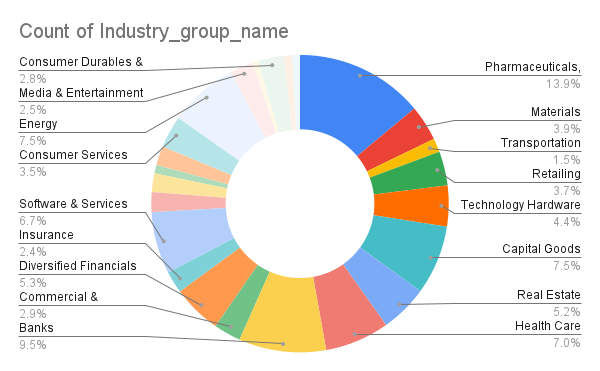

#### Data Processing

Data preparation time: 2 Hours 18 mins

In [ ]:
data = pd.read_csv("data_for_model_filtered.csv")
tickers = list(data["ticker"])
industry_groups = list(data["Industry_group_name"])

summarys = []

df = pd.DataFrame(columns=["ticker","text", "length", "industry_group"])

for ticker, industry_group in tqdm(zip(tickers,industry_groups)):
  if len(ticker) > 0:
    ticker = ticker.replace("/","-")
    info = yf.Ticker(ticker).info
    summary = str(info.get("longBusinessSummary")).lower()

    if (summary != None) and (summary.replace(" ", "") != "none"):
      text_length = len(summary.split(" "))
      new_row = {"ticker":ticker,"text":summary, "length":text_length,"industry_group":industry_group}
      df = df.append(new_row, ignore_index=True)

4746it [2:18:17,  1.75s/it]


In [ ]:
display(df)

,ticker,text,length,industry_group
0,A,"agilent technologies, inc. provides applicatio...",247,"Pharmaceuticals, Biotechnology & Life Sciences"
1,AA,"alcoa corporation, together with its subsidiar...",156,Materials
2,AAL,"american airlines group inc., through its subs...",103,Transportation
3,AAN,"the aaron's company, inc. provides lease-to-ow...",88,Retailing
4,AAOI,"applied optoelectronics, inc. designs, manufac...",73,Technology Hardware & Equipment
...,...,...,...,...
3479,PSTV,"plus therapeutics, inc., a clinical-stage phar...",96,"Pharmaceuticals, Biotechnology & Life Sciences"
3480,BNTC,"benitec biopharma inc., a development-stage bi...",57,"Pharmaceuticals, Biotechnology & Life Sciences"
3481,NUWE,"nuwellis, inc., a medical device company, focu...",138,Health Care Equipment & Services
3482,RADI,"radius global infrastructure, inc., together w...",73,Telecommunication Services


In [ ]:
X = df["text"]
y = df["industry_group"]
buff = []
for each in y:
  buff.append([each])

one_hot = MultiLabelBinarizer()

labels = one_hot.fit_transform(buff)
print(labels)
print(one_hot.classes_)
df['labels'] = list(labels)


[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 1 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 0 0 0]]
['Automobiles & Components' 'Banks' 'Capital Goods'
 'Commercial & Professional Services' 'Consumer Durables & Apparel'
 'Consumer Services' 'Diversified Financials' 'Energy'
 'Food & Staples Retailing' 'Food, Beverage & Tobacco'
 'Health Care Equipment & Services' 'Household & Personal Products'
 'Insurance' 'Materials' 'Media & Entertainment'
 'Pharmaceuticals, Biotechnology & Life Sciences' 'Real Estate'
 'Retailing' 'Semiconductors & Semiconductor Equipment'
 'Software & Services' 'Technology Hardware & Equipment'
 'Telecommunication Services' 'Transportation' 'Utilities']


In [ ]:
display(df)
df.to_csv("train_validation_data.csv", index=False)

,ticker,text,length,industry_group,labels
0,A,"agilent technologies, inc. provides applicatio...",247,"Pharmaceuticals, Biotechnology & Life Sciences","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,AA,"alcoa corporation, together with its subsidiar...",156,Materials,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ..."
2,AAL,"american airlines group inc., through its subs...",103,Transportation,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,AAN,"the aaron's company, inc. provides lease-to-ow...",88,Retailing,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,AAOI,"applied optoelectronics, inc. designs, manufac...",73,Technology Hardware & Equipment,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...,...
3479,PSTV,"plus therapeutics, inc., a clinical-stage phar...",96,"Pharmaceuticals, Biotechnology & Life Sciences","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3480,BNTC,"benitec biopharma inc., a development-stage bi...",57,"Pharmaceuticals, Biotechnology & Life Sciences","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3481,NUWE,"nuwellis, inc., a medical device company, focu...",138,Health Care Equipment & Services,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ..."
3482,RADI,"radius global infrastructure, inc., together w...",73,Telecommunication Services,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


#### Adding GPT3 Ada & BERT Mpnet text Embeddings

In [23]:
def get_embedding_from_gpt3(text, model="text-similarity-ada-001"):
   text = text.replace("\n", " ")
   return openai.Embedding.create(input = [text], model=model)['data'][0]['embedding']

In [ ]:
df = pd.read_csv("train_validation_data.csv")
df['gpt3_ada_embeddings'] = df.text.apply(lambda x: get_embedding_from_gpt3(x, model='text-similarity-ada-001'))
display(df)

,ticker,text,length,industry_group,labels,gpt3_ada_embeddings
0,A,"agilent technologies, inc. provides applicatio...",247,"Pharmaceuticals, Biotechnology & Life Sciences",[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0],"[-0.0006832933286204934, 0.03496784716844559, ..."
1,AA,"alcoa corporation, together with its subsidiar...",156,Materials,[0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0],"[-0.0070811728946864605, 0.01249618735164404, ..."
2,AAL,"american airlines group inc., through its subs...",103,Transportation,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0],"[-0.0005762868677265942, 0.026783619076013565,..."
3,AAN,"the aaron's company, inc. provides lease-to-ow...",88,Retailing,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0],"[-0.03280072659254074, 0.029954906553030014, -..."
4,AAOI,"applied optoelectronics, inc. designs, manufac...",73,Technology Hardware & Equipment,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0],"[0.004034619778394699, 0.015450158156454563, -..."
...,...,...,...,...,...,...
3479,PSTV,"plus therapeutics, inc., a clinical-stage phar...",96,"Pharmaceuticals, Biotechnology & Life Sciences",[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0],"[-0.019013840705156326, 0.020469997078180313, ..."
3480,BNTC,"benitec biopharma inc., a development-stage bi...",57,"Pharmaceuticals, Biotechnology & Life Sciences",[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0],"[8.053638885030523e-05, 0.04349434748291969, -..."
3481,NUWE,"nuwellis, inc., a medical device company, focu...",138,Health Care Equipment & Services,[0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0],"[-0.033278003334999084, 0.01696525700390339, -..."
3482,RADI,"radius global infrastructure, inc., together w...",73,Telecommunication Services,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0],"[-0.007100449874997139, 0.029155272990465164, ..."


In [24]:
pretrained_model = None
def get_embedding_from_bert(texts, model_name='sentence-transformers/all-mpnet-base-v2'):
  global pretrained_model
  if pretrained_model == None: 
    pretrained_model = SentenceTransformer(model_name)
    print("\nBERT Initalized")
  texts_embedding = pretrained_model.encode(texts)
  return list(texts_embedding)

In [ ]:
df['bert_mpnet_embeddings'] = df.text.apply(lambda x: get_embedding_from_bert(x, model_name='sentence-transformers/all-mpnet-base-v2'))
display(df)


BERT Initalized


,ticker,text,length,industry_group,labels,gpt3_ada_embeddings,bert_mpnet_embeddings
0,A,"agilent technologies, inc. provides applicatio...",247,"Pharmaceuticals, Biotechnology & Life Sciences",[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0],"[-0.0006832933286204934, 0.03496784716844559, ...","[0.005483147, -0.0497196, -0.021418154, -0.045..."
1,AA,"alcoa corporation, together with its subsidiar...",156,Materials,[0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0],"[-0.0070811728946864605, 0.01249618735164404, ...","[0.0115718795, -0.007011974, -0.045838922, 0.0..."
2,AAL,"american airlines group inc., through its subs...",103,Transportation,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0],"[-0.0005762868677265942, 0.026783619076013565,...","[-0.035386197, 0.075009964, -0.04238321, 0.018..."
3,AAN,"the aaron's company, inc. provides lease-to-ow...",88,Retailing,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0],"[-0.03280072659254074, 0.029954906553030014, -...","[-0.020007728, 0.030695261, -0.003004037, 0.00..."
4,AAOI,"applied optoelectronics, inc. designs, manufac...",73,Technology Hardware & Equipment,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0],"[0.004034619778394699, 0.015450158156454563, -...","[0.007969643, -0.044641826, -0.04190372, -0.03..."
...,...,...,...,...,...,...,...
3479,PSTV,"plus therapeutics, inc., a clinical-stage phar...",96,"Pharmaceuticals, Biotechnology & Life Sciences",[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0],"[-0.019013840705156326, 0.020469997078180313, ...","[0.06097718, -0.031358555, 0.0032967373, -0.03..."
3480,BNTC,"benitec biopharma inc., a development-stage bi...",57,"Pharmaceuticals, Biotechnology & Life Sciences",[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0],"[8.053638885030523e-05, 0.04349434748291969, -...","[0.034141332, -0.0037670452, 0.0026794092, 0.0..."
3481,NUWE,"nuwellis, inc., a medical device company, focu...",138,Health Care Equipment & Services,[0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0],"[-0.033278003334999084, 0.01696525700390339, -...","[0.011623084, 0.008109173, -0.038580984, -0.03..."
3482,RADI,"radius global infrastructure, inc., together w...",73,Telecommunication Services,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0],"[-0.007100449874997139, 0.029155272990465164, ...","[-0.019708637, -0.010843136, -0.014981794, 0.0..."


In [ ]:
display(df)
df.to_csv("train_validation_data_with_embeddings.csv", index=False)

,ticker,text,length,industry_group,labels,gpt3_ada_embeddings,bert_mpnet_embeddings
0,A,"agilent technologies, inc. provides applicatio...",247,"Pharmaceuticals, Biotechnology & Life Sciences",[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0],"[-0.0006832933286204934, 0.03496784716844559, ...","[0.005483147, -0.0497196, -0.021418154, -0.045..."
1,AA,"alcoa corporation, together with its subsidiar...",156,Materials,[0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0],"[-0.0070811728946864605, 0.01249618735164404, ...","[0.0115718795, -0.007011974, -0.045838922, 0.0..."
2,AAL,"american airlines group inc., through its subs...",103,Transportation,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0],"[-0.0005762868677265942, 0.026783619076013565,...","[-0.035386197, 0.075009964, -0.04238321, 0.018..."
3,AAN,"the aaron's company, inc. provides lease-to-ow...",88,Retailing,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0],"[-0.03280072659254074, 0.029954906553030014, -...","[-0.020007728, 0.030695261, -0.003004037, 0.00..."
4,AAOI,"applied optoelectronics, inc. designs, manufac...",73,Technology Hardware & Equipment,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0],"[0.004034619778394699, 0.015450158156454563, -...","[0.007969643, -0.044641826, -0.04190372, -0.03..."
...,...,...,...,...,...,...,...
3479,PSTV,"plus therapeutics, inc., a clinical-stage phar...",96,"Pharmaceuticals, Biotechnology & Life Sciences",[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0],"[-0.019013840705156326, 0.020469997078180313, ...","[0.06097718, -0.031358555, 0.0032967373, -0.03..."
3480,BNTC,"benitec biopharma inc., a development-stage bi...",57,"Pharmaceuticals, Biotechnology & Life Sciences",[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0],"[8.053638885030523e-05, 0.04349434748291969, -...","[0.034141332, -0.0037670452, 0.0026794092, 0.0..."
3481,NUWE,"nuwellis, inc., a medical device company, focu...",138,Health Care Equipment & Services,[0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0],"[-0.033278003334999084, 0.01696525700390339, -...","[0.011623084, 0.008109173, -0.038580984, -0.03..."
3482,RADI,"radius global infrastructure, inc., together w...",73,Telecommunication Services,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0],"[-0.007100449874997139, 0.029155272990465164, ...","[-0.019708637, -0.010843136, -0.014981794, 0.0..."


In [ ]:
data = pd.read_csv("train_validation_data_with_embeddings.csv")
data['gpt3_ada_embeddings'] = data.gpt3_ada_embeddings.apply(eval).apply(np.array)
data['bert_mpnet_embeddings'] = data.bert_mpnet_embeddings.apply(eval).apply(np.array)
data

,ticker,text,length,industry_group,labels,gpt3_ada_embeddings,bert_mpnet_embeddings
0,A,"agilent technologies, inc. provides applicatio...",247,"Pharmaceuticals, Biotechnology & Life Sciences",[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0],"[-0.0006832933286204934, 0.03496784716844559, ...","[0.005483147, -0.0497196, -0.021418154, -0.045..."
1,AA,"alcoa corporation, together with its subsidiar...",156,Materials,[0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0],"[-0.0070811728946864605, 0.01249618735164404, ...","[0.0115718795, -0.007011974, -0.045838922, 0.0..."
2,AAL,"american airlines group inc., through its subs...",103,Transportation,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0],"[-0.0005762868677265942, 0.026783619076013565,...","[-0.035386197, 0.075009964, -0.04238321, 0.018..."
3,AAN,"the aaron's company, inc. provides lease-to-ow...",88,Retailing,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0],"[-0.03280072659254074, 0.029954906553030014, -...","[-0.020007728, 0.030695261, -0.003004037, 0.00..."
4,AAOI,"applied optoelectronics, inc. designs, manufac...",73,Technology Hardware & Equipment,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0],"[0.004034619778394699, 0.015450158156454563, -...","[0.007969643, -0.044641826, -0.04190372, -0.03..."
...,...,...,...,...,...,...,...
3479,PSTV,"plus therapeutics, inc., a clinical-stage phar...",96,"Pharmaceuticals, Biotechnology & Life Sciences",[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0],"[-0.019013840705156326, 0.020469997078180313, ...","[0.06097718, -0.031358555, 0.0032967373, -0.03..."
3480,BNTC,"benitec biopharma inc., a development-stage bi...",57,"Pharmaceuticals, Biotechnology & Life Sciences",[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0],"[8.053638885030523e-05, 0.04349434748291969, -...","[0.034141332, -0.0037670452, 0.0026794092, 0.0..."
3481,NUWE,"nuwellis, inc., a medical device company, focu...",138,Health Care Equipment & Services,[0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0],"[-0.033278003334999084, 0.01696525700390339, -...","[0.011623084, 0.008109173, -0.038580984, -0.03..."
3482,RADI,"radius global infrastructure, inc., together w...",73,Telecommunication Services,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0],"[-0.007100449874997139, 0.029155272990465164, ...","[-0.019708637, -0.010843136, -0.014981794, 0.0..."


Max length of business sumarry: The maximum sequence length the BERT model accepts is **384**

In [ ]:
buff = list(data['length'])
buff.sort(reverse=True)
print(buff)

[751, 668, 598, 583, 467, 335, 335, 324, 324, 316, 307, 304, 303, 301, 299, 295, 294, 294, 292, 291, 290, 289, 288, 288, 288, 285, 285, 284, 284, 283, 283, 283, 283, 282, 282, 280, 280, 280, 280, 279, 279, 279, 278, 278, 278, 278, 278, 278, 277, 277, 277, 277, 277, 276, 276, 276, 275, 275, 275, 275, 275, 275, 275, 275, 275, 275, 275, 275, 274, 274, 274, 274, 274, 274, 274, 273, 273, 273, 273, 273, 273, 273, 273, 273, 273, 273, 273, 272, 272, 272, 272, 272, 272, 271, 271, 271, 271, 271, 271, 271, 271, 271, 271, 271, 270, 270, 270, 270, 270, 270, 270, 270, 269, 269, 269, 269, 269, 269, 269, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 266, 265, 265, 265, 265, 265, 265, 265, 265, 265, 265, 265, 265, 265, 265, 265, 265, 265, 264, 264, 264, 264, 264, 264, 264, 264, 264, 264, 264, 264, 264, 264, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263,

### Traning Industry group classification Model with Pre-trained GPT3 Ada Embeddings with all the data apart from SNP500 Data.
**Why:** To get the Predictions for the SNP500 Validation data.<br>
Training Data:<br>
1. 3484 - 482(SNP500)
2. 191(own data)

Test Data:<br>
1. 482(SNP500)

In [ ]:
snp_500_tickers = list(pd.read_csv("sp500-with-gics.csv")["Ticker"])
train_val_data = pd.read_csv("train_validation_data_with_embeddings.csv")[["ticker","text","labels","gpt3_ada_embeddings","bert_mpnet_embeddings"]]
test_data = pd.read_csv("test_data_with_embeddings.csv")[["Ticker", "Annual Report Description","labels","gpt3_ada_embeddings","bert_mpnet_embeddings"]]
test_data.rename(columns = {'Annual Report Description':'text', 'Ticker':'ticker'}, inplace = True)

train_val_data_without_snp500 = train_val_data[~train_val_data['ticker'].isin(snp_500_tickers)]
snp_500_data = train_val_data[train_val_data['ticker'].isin(snp_500_tickers)]

train_data = pd.concat([train_val_data_without_snp500, test_data])

In [ ]:
train_data

,ticker,text,labels,gpt3_ada_embeddings,bert_mpnet_embeddings
1,AA,"alcoa corporation, together with its subsidiar...",[0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0],"[-0.0070811728946864605, 0.01249618735164404, ...","[0.0115718795, -0.007011974, -0.045838922, 0.0..."
3,AAN,"the aaron's company, inc. provides lease-to-ow...",[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0],"[-0.03280072659254074, 0.029954906553030014, -...","[-0.020007728, 0.030695261, -0.003004037, 0.00..."
4,AAOI,"applied optoelectronics, inc. designs, manufac...",[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0],"[0.004034619778394699, 0.015450158156454563, -...","[0.007969643, -0.044641826, -0.04190372, -0.03..."
5,AAON,"aaon, inc., together with its subsidiaries, en...",[0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0],"[-0.0073268720880150795, 0.013084076344966888,...","[-0.022039626, -0.028250033, -0.035043567, 0.0..."
8,AAT,"american assets trust, inc. is a full service,...",[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0],"[-0.02832534909248352, 0.016429968178272247, 0...","[-0.041082174, 0.07263538, -0.03760377, 0.0223..."
...,...,...,...,...,...
186,VZ,Verizon Communications Inc. (Verizon or the Co...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0],"[-0.02583405189216137, 0.04515673965215683, -0...","[0.024315108, 0.010809237, -0.038575735, -0.04..."
187,WMT,Our strategy is to make every day easier for b...,[0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0],"[-0.021060192957520485, 0.02832055278122425, 0...","[0.018355936, 0.001890081, -0.01986655, -0.026..."
188,WMT,Sam's Club operates in 44 states in the U.S. a...,[0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0],"[-0.0017585509922355413, 0.024876682087779045,...","[0.011270718, 0.01119284, -0.0058826287, -0.01..."
189,WHR,As a 110-year old company with a legacy of suc...,[0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0],"[-0.00576607882976532, 0.03873300552368164, 0....","[-0.022816425, 0.0047790483, -0.02041145, -0.0..."


In [ ]:
snp_500_data

,ticker,text,labels,gpt3_ada_embeddings,bert_mpnet_embeddings
0,A,"agilent technologies, inc. provides applicatio...",[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0],"[-0.0006832933286204934, 0.03496784716844559, ...","[0.005483147, -0.0497196, -0.021418154, -0.045..."
2,AAL,"american airlines group inc., through its subs...",[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0],"[-0.0005762868677265942, 0.026783619076013565,...","[-0.035386197, 0.075009964, -0.04238321, 0.018..."
6,AAP,"advance auto parts, inc. provides automotive r...",[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0],"[-0.003949782345443964, 0.022095806896686554, ...","[-0.011582102, -0.0041202563, -0.041514862, 0...."
7,AAPL,"apple inc. designs, manufactures, and markets ...",[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0],"[-0.016530999913811684, 0.034571487456560135, ...","[0.03761599, -0.008080051, -0.023031274, -0.02..."
10,ABBV,"abbvie inc. discovers, develops, manufactures,...",[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0],"[-0.056526828557252884, 0.032629139721393585, ...","[0.051477596, -0.023919167, 0.007047822, -0.04..."
...,...,...,...,...,...
2576,AMCR,"amcor plc develops, produces, and sells packag...",[0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0],"[-0.025609629228711128, 0.020635247230529785, ...","[0.016311802, -0.016641952, -0.02654225, -0.01..."
2644,LUMN,"lumen technologies, inc., a facilities-based t...",[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0],"[-0.017612431198358536, 0.02768424153327942, -...","[0.047772232, 0.013790234, -0.032774683, -0.00..."
2718,VTRS,viatris inc. operates as a healthcare company ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0],"[-0.012587538920342922, 0.026857569813728333, ...","[0.0691458, -0.030710572, -0.011613664, -0.001..."
2759,VNT,vontier corporation engages in the research an...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0],"[-0.02106001041829586, -0.000541810120921582, ...","[-0.03386359, -0.009945026, -0.037958283, -0.0..."


Helpers

In [7]:
# setting seed for all randomness
def set_seed():
  np.random.seed(1786)
  torch.manual_seed(1786)
  random.seed(1786)


# convert string type to list of float type
def manuplate_labels(y): 
  y = y.replace("[","")
  y = y.replace("]","")
  splits = y.split(" ")
  splits = [float(x) for x in splits]
  return list(splits)

In [ ]:
train_data['labels'] = train_data.labels.apply(lambda x: manuplate_labels(x))
train_data['gpt3_ada_embeddings'] = train_data.gpt3_ada_embeddings.apply(eval).apply(np.array)
train_data['bert_mpnet_embeddings'] = train_data.bert_mpnet_embeddings.apply(eval).apply(np.array)

snp_500_data['labels'] = snp_500_data.labels.apply(lambda x: manuplate_labels(x))
snp_500_data['gpt3_ada_embeddings'] = snp_500_data.gpt3_ada_embeddings.apply(eval).apply(np.array)
snp_500_data['bert_mpnet_embeddings'] = snp_500_data.bert_mpnet_embeddings.apply(eval).apply(np.array)

In [19]:
class TextDataset(torch.utils.data.Dataset):
  def __init__(self, split="train", selection="bert"):

    global train_data
    global snp_500_data

    if selection == "bert":
      if split == "train":
        X = list(train_data["bert_mpnet_embeddings"])
        Y = list(train_data["labels"])
      else:
        X = list(snp_500_data["bert_mpnet_embeddings"])
        Y = list(snp_500_data["labels"])
        
    elif selection == "gpt3":
      if split == "train":
        X = list(train_data["gpt3_ada_embeddings"])
        Y = list(train_data["labels"])
      else:
        X = list(snp_500_data["gpt3_ada_embeddings"])
        Y = list(snp_500_data["labels"])
    else:
      assert selection in ["bert", "gpt3"], "Selection is not available!"
      
    self.X = X 
    self.Y = torch.tensor(Y)
      
  def __len__(self):
    return len(self.X)

  def __getitem__(self, idx):
    return self.X[idx], self.Y[idx]

Model architecture for Classification

In [20]:
# def get_embedding_from_gpt3(texts, model_name="text-similarity-ada-001"):
#   texts_embedding = []
#   for text in texts:
#     text = text.replace("\n", " ")
#     text_embedding = openai.Embedding.create(input = [text], model=model_name)['data'][0]['embedding']
#     texts_embedding.append(text_embedding)
#   return texts_embedding

In [21]:
# pretrained_model = None
# def get_embedding_from_bert(texts, model_name='sentence-transformers/all-mpnet-base-v2'):
#   global pretrained_model
#   if pretrained_model == None: 
#     pretrained_model = SentenceTransformer(model_name)
#     print("\nBERT Initalized")
#   texts_embedding = pretrained_model.encode(texts)
#   return texts_embedding

In [43]:
# setting seeds
set_seed()

class Industry_Group_Classification_Model(torch.nn.Module):
  def __init__(self, emb_length=768, pred_length=24):
      super().__init__()
      self.layer1 = nn.Linear(emb_length, int(emb_length/2))
      self.layer2 = nn.Linear(int(emb_length/2), int(emb_length/4))
      self.layer3 = nn.Linear(int(emb_length/4), int(emb_length/12))
      self.layer4 = nn.Linear(int(emb_length/12), pred_length)
      # self.drop_out = nn.Dropout(p=0.2)
      # self.embedding = nn.Embedding.from_pretrained(glove.vectors, freeze=freeze)
      # self.conv1 = nn.Conv2d(1, n_1, kernel_size = [k_1,embedding_size], bias=False)
      # self.conv2 = nn.Conv2d(1, n_2, kernel_size = [k_2,embedding_size], bias=False)
      # self.layer1 = nn.Linear(n_1+n_2, 1)
      
  def forward(self, x_emb):
    x_emb = torch.as_tensor(x_emb, dtype=torch.float)
    if torch.cuda.is_available(): x_emb = x_emb.cuda()
    
    out1 = F.leaky_relu(self.layer1(x_emb))
    out2 = F.leaky_relu(self.layer2(out1))
    out3 = F.leaky_relu(self.layer3(out2))
    prediction = self.layer4(out3)

    return prediction

In [ ]:
print("Train Count: {}, Test Count:{}".format(len(train_data.text), len(snp_500_data.text)))

Train Count: 3193, Test Count:482


In [ ]:
def train_classifier(selection, emb_length, pred_length, batch_size, epochs, lr):

  set_seed()
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  print ("Using device:", device)

  train_dataset = TextDataset("train", selection)
  val_dataset = TextDataset("validation", selection)

  train_dataloader = torch.utils.data.DataLoader(
      dataset=train_dataset, 
      batch_size=batch_size, 
      shuffle=False)

  validation_dataloader = torch.utils.data.DataLoader(
      dataset=val_dataset, 
      batch_size=batch_size, 
      shuffle=False)
  
  torch.cuda.empty_cache()
  use_cuda = True

  # initalizing the model
  classification_model = None
  classification_model = Industry_Group_Classification_Model(emb_length=emb_length, pred_length=pred_length)

  if use_cuda and torch.cuda.is_available():
    classification_model.cuda()
    print('CUDA is available!  Training on GPU ...')
  else:
    print('CUDA is not available.  Training on CPU ...')

  # initalizing the BCE entropy loss
  criterion = nn.BCEWithLogitsLoss()

  # initalizing the optimizer
  optimizer = optim.Adam(classification_model.parameters(), lr=lr)

  # initalizing storages
  train_losses = []
  validation_losses = []
  train_acc = []
  validation_acc = []
  

  for epoch in tqdm(range(epochs)):
    train_loss = 0.0
    n = 0
    correct = 0
    total = 0

    # train loop
    classification_model.train()
    for x, y in iter(train_dataloader):
      if torch.cuda.is_available(): y = y.cuda()
      pred = classification_model(x)

      ## For one-hot accuracy calculation
      outputs = torch.sigmoid(pred)

      predicted = torch.topk(outputs, 1)[1]
      true = torch.topk(y, 1)[1]
      total += y.size(0)
      correct += (predicted == true).sum().item()


      ## For multi-label accuracy calculation
      # outputs = torch.sigmoid(pred)    
      # predicted = torch.round(outputs)
      # print("Pred:", predicted)
      # print("True:",y)
      # total += y.size(0)
      # correct += (predicted == y).sum().item()

      loss = criterion(pred, y.float())
      loss.backward()
      optimizer.step()             
      optimizer.zero_grad()
      train_loss = train_loss + float(loss)/batch_size
      n = n + 1
    
    # appending average loss for each epoch
    train_losses.append(train_loss/n)

    # appending accuracy for each epoch
    train_acc.append(correct/total)

    # evaluation loop
    classification_model.eval()
    with torch.no_grad():
        validation_loss = 0.0
        q = 0
        correct = 0
        total = 0
        for x, y in iter(validation_dataloader):
          if torch.cuda.is_available(): y = y.cuda()

          pred = classification_model(x)

          ## For one-hot accuracy calculation
          outputs = torch.sigmoid(pred)

          predicted = torch.topk(outputs, 1)[1]
          true = torch.topk(y, 1)[1]
          total += y.size(0)
          correct += (predicted == true).sum().item()

          ## For multi-label accuracy calculation
          # outputs = torch.sigmoid(pred)      
          # predicted = torch.round(outputs)
          # total += y.size(0)
          # correct += (predicted == y).sum().item()    

          loss = criterion(pred, y.float())
          validation_loss = validation_loss + float(loss)/batch_size
          q = q + 1
        
        # appending average loss for each epoch
        validation_losses.append(validation_loss/q)
        # appending accuracy for each epoch
        validation_acc.append(correct/total)

  # plotting loss curves
  print("\n")
  plt.figure(figsize=(12,8))
  plt.plot(range(epochs), train_losses, label="Train loss")
  plt.plot(range(epochs), validation_losses, label="Validation loss")
  plt.xlabel("Epochs")
  plt.ylabel("Binary-Entropic-loss")
  plt.legend()
  plt.show()

  # plotting Accuracy curves
  print("\n")
  plt.figure(figsize=(12,8))
  plt.plot(range(epochs), train_acc, label="Train Acc")
  plt.plot(range(epochs), validation_acc, label="Validation Acc")
  plt.xlabel("Epochs")
  plt.ylabel("Accuracy")
  plt.legend()
  plt.show()

  print("Train Acc:", train_acc[-1])
  print("Validation Acc:", validation_acc[-1])

  return classification_model

#### Using Pretrained BERT Embeddings for Classification
Found that with Batch size = 64, learning Rate = 0.001 & epochs = 25. The Classification model was able to converge without any Overfitting or Noisy gradients update.

Using device: cuda
CUDA is available!  Training on GPU ...


100%|██████████| 25/25 [00:05<00:00,  4.17it/s]


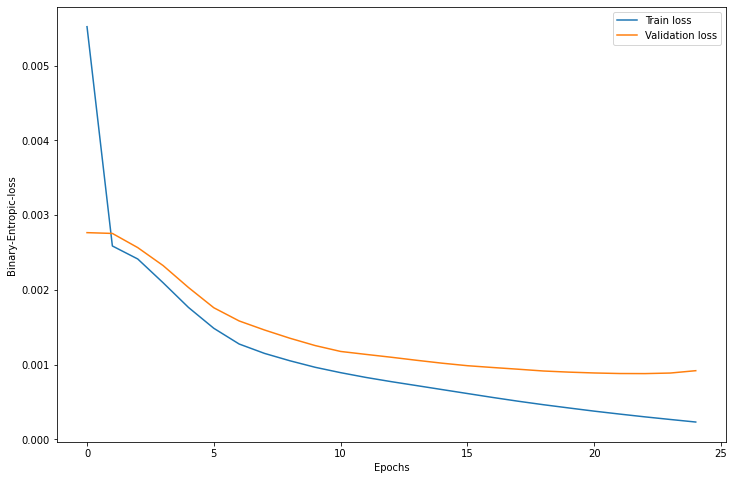

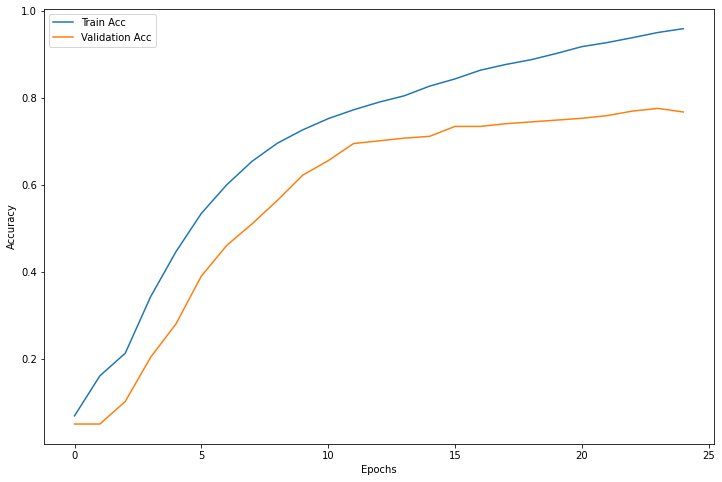

Train Acc: 0.9592859379893517
Validation Acc: 0.7676348547717843


In [ ]:
classification_model_bert = train_classifier(selection="bert", emb_length=768, pred_length=24, batch_size=64, epochs=25, lr=0.001)

In [ ]:
modelsavename = "Phase2:selection=bert-emb_length=768-pred_length=24-batch_size=64-epochs=25-lr=0.001.pt"
torch.save(classification_model_bert.state_dict(), modelsavename)
# classification_model.load_state_dict(torch.load(modelsavename))

#### Using Pretrained GPT3 Embeddings for Classification
Found that with Batch size = 16, learning Rate = 0.001 & epochs = 25. The Classification model was able to converge without any Overfitting or Noisy gradients update.

Using device: cuda
CUDA is available!  Training on GPU ...


100%|██████████| 25/25 [00:12<00:00,  2.07it/s]

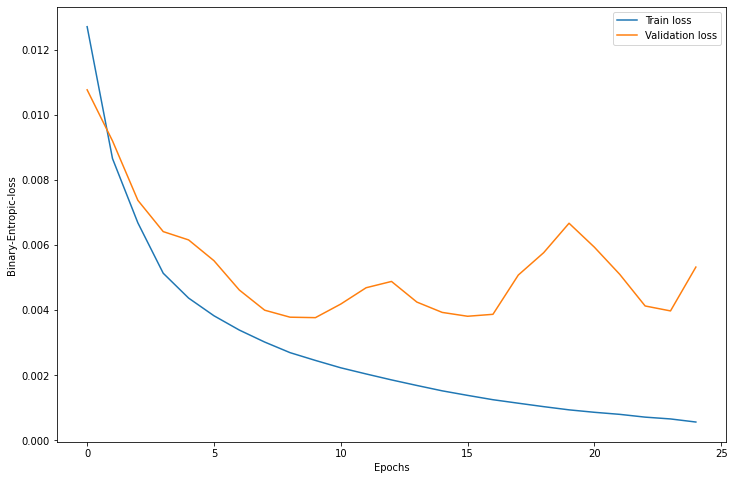

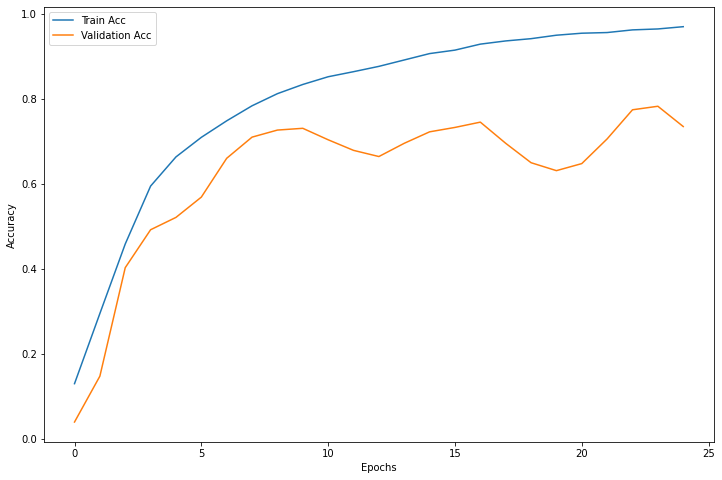

Train Acc: 0.969307860945819
Validation Acc: 0.7344398340248963


In [ ]:
classification_model_gpt3 = train_classifier(selection="gpt3", emb_length=1024, pred_length=24, batch_size=16, epochs=25, lr=0.001)

In [ ]:
modelsavename = "Phase2:selection=gpt3-emb_length=1024-pred_length=24-batch_size=16-epochs=25-lr=0.001.pt"
torch.save(classification_model_gpt3.state_dict(), modelsavename)

### Getting Predicted labels for SNP500 with Pre-trained GPT3 Embeddings

In [ ]:
import torch
from torchvision import models
from torchsummary import summary

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
def get_test_acc(X, Y, model, k_set=0):
  total = 0
  correct = 0
  for x, y in zip(list(X), list(Y)):
    if torch.cuda.is_available():
      y = torch.tensor(y).cuda()

    pred = model(x)

    ## For one-hot accuracy calculation
    outputs = torch.sigmoid(pred)
    k_value = int(y.count_nonzero())
    if k_value > k_set:
      predicted = torch.topk(outputs, k_value)[1]
      true = torch.topk(y, k_value)[1]
      total += 1
      correct += (predicted.sort()[0] == true.sort()[0]).sum().item()

  print("Test Acc:", (correct/total))

In [ ]:
set_seed()
classification_model_gpt3 = None
classification_model_gpt3 = Industry_Group_Classification_Model(emb_length=1024, pred_length=24)
classification_model_gpt3.load_state_dict(torch.load("Phase2:selection=gpt3-emb_length=1024-pred_length=24-batch_size=16-epochs=25-lr=0.001.pt"))

summary(classification_model_gpt3.to(device), (1, 1024))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 512]         524,800
            Linear-2               [-1, 1, 256]         131,328
            Linear-3                [-1, 1, 85]          21,845
            Linear-4                [-1, 1, 24]           2,064
Total params: 680,037
Trainable params: 680,037
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 2.59
Estimated Total Size (MB): 2.60
----------------------------------------------------------------


In [ ]:
get_test_acc(X=snp_500_data["gpt3_ada_embeddings"], Y=snp_500_data["labels"], model=classification_model_gpt3, k_set=0)

Test Acc: 0.7344398340248963


In [ ]:
snp_500_data["preditions"] = None
snp_500_data["predictions_score"] = None
snp_500_data["original"] = None
snp_500_data["hand_labeled"] = None
snp_500_data = snp_500_data.reset_index(drop=True)

labels = np.array(['Automobiles & Components','Banks','Capital Goods',
 'Commercial & Professional Services','Consumer Durables & Apparel',
 'Consumer Services','Diversified Financials','Energy',
 'Food & Staples Retailing','Food, Beverage & Tobacco',
 'Health Care Equipment & Services','Household & Personal Products',
 'Insurance','Materials','Media & Entertainment',
 'Pharmaceuticals, Biotechnology & Life Sciences','Real Estate',
 'Retailing','Semiconductors & Semiconductor Equipment',
 'Software & Services','Technology Hardware & Equipment',
 'Telecommunication Services','Transportation','Utilities'])

i = 0
for x, y in zip(list(snp_500_data["gpt3_ada_embeddings"]), list(snp_500_data["labels"])):
    if torch.cuda.is_available():
      y = torch.tensor(y).cuda()

    pred = classification_model_gpt3(x)

    ## For one-hot accuracy calculation
    outputs = torch.sigmoid(pred)
    predicted = torch.topk(outputs, 5)[1].cpu().detach().numpy()
    predictions_score = torch.topk(outputs, 5)[0].cpu().detach().numpy().astype(np.float)
    true = torch.topk(y, 1)[1].cpu().detach().numpy()
    predicted = list(labels[predicted])
    true = list(labels[true])
    snp_500_data["preditions"][i] = predicted
    snp_500_data["predictions_score"][i] = predictions_score
    snp_500_data["original"][i] = true
    i += 1

snp_500_data

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


,ticker,text,labels,gpt3_ada_embeddings,bert_mpnet_embeddings,preditions,original,hand_labeled,predictions_score
0,A,"agilent technologies, inc. provides applicatio...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.0006832933286204934, 0.03496784716844559, ...","[0.005483147, -0.0497196, -0.021418154, -0.045...","[Health Care Equipment & Services, Pharmaceuti...","[Pharmaceuticals, Biotechnology & Life Sciences]",None,"[0.9836909770965576, 0.04492281377315521, 0.00..."
1,AAL,"american airlines group inc., through its subs...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.0005762868677265942, 0.026783619076013565,...","[-0.035386197, 0.075009964, -0.04238321, 0.018...","[Capital Goods, Transportation, Energy, Teleco...",[Transportation],None,"[0.9727743864059448, 0.3698714077472687, 0.005..."
2,AAP,"advance auto parts, inc. provides automotive r...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.003949782345443964, 0.022095806896686554, ...","[-0.011582102, -0.0041202563, -0.041514862, 0....","[Retailing, Consumer Durables & Apparel, Comme...",[Retailing],None,"[0.30650094151496887, 0.11431105434894562, 0.0..."
3,AAPL,"apple inc. designs, manufactures, and markets ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.016530999913811684, 0.034571487456560135, ...","[0.03761599, -0.008080051, -0.023031274, -0.02...","[Technology Hardware & Equipment, Semiconducto...",[Technology Hardware & Equipment],None,"[0.8858805894851685, 0.03396274894475937, 0.01..."
4,ABBV,"abbvie inc. discovers, develops, manufactures,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.056526828557252884, 0.032629139721393585, ...","[0.051477596, -0.023919167, 0.007047822, -0.04...","[Pharmaceuticals, Biotechnology & Life Science...","[Pharmaceuticals, Biotechnology & Life Sciences]",None,"[0.9999055862426758, 0.00020599424897227436, 5..."
...,...,...,...,...,...,...,...,...,...
477,AMCR,"amcor plc develops, produces, and sells packag...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.025609629228711128, 0.020635247230529785, ...","[0.016311802, -0.016641952, -0.02654225, -0.01...","[Materials, Capital Goods, Food, Beverage & To...",[Materials],None,"[0.9994007349014282, 0.00031102419598028064, 0..."
478,LUMN,"lumen technologies, inc., a facilities-based t...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.017612431198358536, 0.02768424153327942, -...","[0.047772232, 0.013790234, -0.032774683, -0.00...","[Technology Hardware & Equipment, Capital Good...",[Telecommunication Services],None,"[0.835749626159668, 0.006305135320872068, 0.00..."
479,VTRS,viatris inc. operates as a healthcare company ...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.012587538920342922, 0.026857569813728333, ...","[0.0691458, -0.030710572, -0.011613664, -0.001...","[Pharmaceuticals, Biotechnology & Life Science...","[Pharmaceuticals, Biotechnology & Life Sciences]",None,"[0.9998083710670471, 0.0008753939182497561, 5...."
480,VNT,vontier corporation engages in the research an...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.02106001041829586, -0.000541810120921582, ...","[-0.03386359, -0.009945026, -0.037958283, -0.0...","[Capital Goods, Materials, Automobiles & Compo...",[Technology Hardware & Equipment],None,"[0.9779175519943237, 0.0638062059879303, 0.040..."


In [ ]:
snp_500_data_to_save = snp_500_data[["ticker", "text", "original","preditions","predictions_score","hand_labeled"]]
snp_500_data_to_save.to_excel("snp500_with_predictions.xlsx",index=False)

### Advance Fine-tunning Experiments of Industry Group classification model


**Available data:**
1. Dataset_1= Single labeled data: 3484 - 319(SNP500) (Collected from Internet)
2. Dataset_2= Multi labeled data: 319(SNP500) (Portion of SNP500 which is Hand labeled data)
3. Dataset_3= Single labeled data: 158 (Extracted text from GICS Industry group defenation)
4. Dataset_4= Multi labeled data: 197 (Hand labeled data, will be using this as test set)

**Note:** The Validation set & Test set for all the classification models will be Multi labeled data with 197 samples from here on.<br>

Test data Distribution: {1: 147, 2: 47, 3: 3}

**Experiments:**<br>
1. Training model with only single label data & verfiying performance on test data.
2. Using weights from experiment 1 and fine-tunning with our own hand labeled data(with multi-labels) & verfiying performance on test data.
3. Training model with complete data in hand & verfiying performance on test data.
4. Training model with only our own hand labeled data(with multi-labels) & verfiying performance on test data.

#### Data Handling
Creating dataset_1, dataset_2, dataset_3, dataset_4 parquet files. Saving all the files as parquet to save pre-processing time.

In [170]:
# test_v2 = pd.read_parquet('test_data_v2_with_BERT_embeddings.parquet')
# test_v2.rename(columns = {'Annual Report Description':'text', 'Ticker':'ticker'}, inplace = True)
# test_v2['bert_mpnet_embeddings'] = test_v2.text.apply(lambda x: get_embedding_from_bert(x, model_name='sentence-transformers/all-mpnet-base-v2'))
# test_v2['gpt3_ada_embeddings'] = test_v2.text.apply(lambda x: get_embedding_from_gpt3(x, model='text-similarity-ada-001'))
# display(test_v2)
# test_v2.to_parquet("test_data_v2_with_embeddings.parquet",index=False)

In [26]:
snp500_hand_labeled = pd.read_parquet('snp500_assisted_labelled.merged.parquet')
snp500_hand_labeled = snp500_hand_labeled.sort_values('ticker', ascending=True)
snp500_hand_labeled.reset_index(drop=True, inplace=True)
snp500_hand_labeled

,ticker,text,original,preditions,predictions_score,hand_labeled
0,A,"agilent technologies, inc. provides applicatio...","Pharmaceuticals, Biotechnology & Life Sciences","[Health Care Equipment & Services, Pharmaceuti...",[9.83690977e-01 4.49228138e-02 9.08404589e-03 ...,"[Health Care Equipment & Services, Pharmaceuti..."
1,AAL,"american airlines group inc., through its subs...",Transportation,"[Capital Goods, Transportation, Energy, Teleco...",[9.72774386e-01 3.69871408e-01 5.05699404e-03 ...,[Transportation]
2,AAP,"advance auto parts, inc. provides automotive r...",Retailing,"[Retailing, Consumer Durables & Apparel, Comme...",[0.30650094 0.11431105 0.00187741 0.00144116 0...,[Retailing]
3,AAPL,"apple inc. designs, manufactures, and markets ...",Technology Hardware & Equipment,"[Technology Hardware & Equipment, Semiconducto...",[0.88588059 0.03396275 0.01135118 0.01008411 0...,"[Technology Hardware & Equipment, Commercial &..."
4,ABBV,"abbvie inc. discovers, develops, manufactures,...","Pharmaceuticals, Biotechnology & Life Sciences","[Pharmaceuticals, Biotechnology & Life Science...",[9.99905586e-01 2.05994249e-04 5.00014321e-05 ...,"[Pharmaceuticals, Biotechnology & Life Sciences]"
...,...,...,...,...,...,...
314,WRK,"westrock company, together with its subsidiari...",Materials,"[Materials, Commercial & Professional Services...",[0.98203295 0.00854665 0.00491344 0.00447505 0...,[Materials]
315,WYNN,"wynn resorts, limited designs, develops, and o...",Consumer Services,"[Consumer Services, Retailing, Media & Enterta...",[9.81280744e-01 5.06780863e-01 1.49636623e-03 ...,[Consumer Services]
316,XOM,exxon mobil corporation explores for and produ...,Energy,"[Energy, Materials, Health Care Equipment & Se...",[9.37189400e-01 2.48898789e-01 2.08895162e-05 ...,[Energy]
317,YUM,"yum! brands, inc., together with its subsidiar...",Consumer Services,"[Consumer Services, Commercial & Professional ...",[0.08676372 0.06242379 0.01985377 0.00439079 0...,[Consumer Services]


In [27]:
train_val_data = pd.read_csv("train_validation_data_with_embeddings.csv")[["ticker","text","labels","gpt3_ada_embeddings","bert_mpnet_embeddings"]]

dataset_1 = train_val_data[~train_val_data['ticker'].isin(list(snp500_hand_labeled["ticker"]))]
dataset_2 = train_val_data[train_val_data['ticker'].isin(list(snp500_hand_labeled["ticker"]))]
dataset_2 = dataset_2.sort_values('ticker', ascending=True)

dataset_1['labels'] = dataset_1.labels.apply(lambda x: manuplate_labels(x))
dataset_1['gpt3_ada_embeddings'] = dataset_1.gpt3_ada_embeddings.apply(eval).apply(np.array)
dataset_1['bert_mpnet_embeddings'] = dataset_1.bert_mpnet_embeddings.apply(eval).apply(np.array)
dataset_1.reset_index(drop=True, inplace=True)

dataset_2['gpt3_ada_embeddings'] = dataset_2.gpt3_ada_embeddings.apply(eval).apply(np.array)
dataset_2['bert_mpnet_embeddings'] = dataset_2.bert_mpnet_embeddings.apply(eval).apply(np.array)
dataset_2.reset_index(drop=True, inplace=True)
one_hot = MultiLabelBinarizer()
labels = one_hot.fit_transform(snp500_hand_labeled['hand_labeled'])
dataset_2['labels'] = list(labels)
dataset_2['labels'] = dataset_2['labels'].apply(lambda x: [float(y) for y in x])


dataset_3 = pd.read_csv("gics_original_ind_group_text_with_embeddings.csv")[["text","labels","gpt3_ada_embeddings","bert_mpnet_embeddings"]]
dataset_3['labels'] = dataset_3.labels.apply(lambda x: manuplate_labels(x))
dataset_3['gpt3_ada_embeddings'] = dataset_3.gpt3_ada_embeddings.apply(eval).apply(np.array)
dataset_3['bert_mpnet_embeddings'] = dataset_3.bert_mpnet_embeddings.apply(eval).apply(np.array)

# dataset_4 = pd.read_csv("test_data_with_embeddings.csv")[["Ticker", "Annual Report Description","labels","gpt3_ada_embeddings","bert_mpnet_embeddings"]]
# dataset_4.rename(columns = {'Annual Report Description':'text', 'Ticker':'ticker'}, inplace = True)
# dataset_4['labels'] = dataset_4.labels.apply(lambda x: manuplate_labels(x))
# dataset_4['gpt3_ada_embeddings'] = dataset_4.gpt3_ada_embeddings.apply(eval).apply(np.array)
# dataset_4['bert_mpnet_embeddings'] = dataset_4.bert_mpnet_embeddings.apply(eval).apply(np.array)

dataset_4 = pd.read_parquet('test_data_v2_with_embeddings.parquet')[["ticker", "text","labels","gpt3_ada_embeddings","bert_mpnet_embeddings"]]


dataset_1.to_parquet("dataset_1.parquet",index=False)
dataset_2.to_parquet("dataset_2.parquet",index=False)
dataset_3.to_parquet("dataset_3.parquet",index=False)
dataset_4.to_parquet("dataset_4.parquet",index=False)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pan

Test Distribution: {1: 147, 2: 47, 3: 3}

#### Helpers

In [225]:
# setting seed for all randomness
def set_seed():
  np.random.seed(1786)
  torch.manual_seed(1786)
  random.seed(1786)


# convert string type to list of float type
def manuplate_labels(y): 
  y = y.replace("[","")
  y = y.replace("]","")
  splits = y.split(" ")
  splits = [float(x) for x in splits]
  return list(splits)

In [226]:
# setting seeds
set_seed()

class Industry_Group_Classification_Model(torch.nn.Module):
  def __init__(self, emb_length=768, pred_length=24):
      super().__init__()
      self.layer1 = nn.Linear(emb_length, int(emb_length/2))
      self.layer2 = nn.Linear(int(emb_length/2), int(emb_length/4))
      self.layer3 = nn.Linear(int(emb_length/4), int(emb_length/12))
      self.layer4 = nn.Linear(int(emb_length/12), pred_length)
      
  def forward(self, x_emb):
    x_emb = torch.as_tensor(x_emb, dtype=torch.float)
    if torch.cuda.is_available(): x_emb = x_emb.cuda()
    
    out1 = F.leaky_relu(self.layer1(x_emb))
    out2 = F.leaky_relu(self.layer2(out1))
    out3 = F.leaky_relu(self.layer3(out2))
    prediction = self.layer4(out3)

    return prediction

In [227]:
class TextDataset(torch.utils.data.Dataset):
  def __init__(self, split="train", selection="bert"):

    global train_data
    global test_data

    if selection == "bert":
      if split == "train":
        X = list(train_data["bert_mpnet_embeddings"])
        Y = list(train_data["labels"])
      else:
        X = list(test_data["bert_mpnet_embeddings"])
        Y = list(test_data["labels"])
        
    elif selection == "gpt3":
      if split == "train":
        X = list(train_data["gpt3_ada_embeddings"])
        Y = list(train_data["labels"])
      else:
        X = list(test_data["gpt3_ada_embeddings"])
        Y = list(test_data["labels"])
    else:
      assert selection in ["bert", "gpt3"], "Selection is not available!"
      
    self.X = X 
    self.Y = torch.tensor(Y)
      
  def __len__(self):
    return len(self.X)

  def __getitem__(self, idx):
    return self.X[idx], self.Y[idx]

In [228]:
def train_classifier(selection, emb_length, pred_length, batch_size, epochs, lr, cut_off, load_pretrained=None):

  set_seed()
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  print ("Using device:", device)

  train_dataset = TextDataset("train", selection)
  val_dataset = TextDataset("validation", selection)

  train_dataloader = torch.utils.data.DataLoader(
      dataset=train_dataset, 
      batch_size=batch_size, 
      shuffle=False)

  validation_dataloader = torch.utils.data.DataLoader(
      dataset=val_dataset, 
      batch_size=batch_size, 
      shuffle=False)
  
  torch.cuda.empty_cache()
  use_cuda = True


  if load_pretrained == None:
    # initalizing the model
    classification_model = None
    classification_model = Industry_Group_Classification_Model(emb_length=emb_length, pred_length=pred_length)
  else:
    classification_model = load_pretrained


  if use_cuda and torch.cuda.is_available():
    classification_model.cuda()
    print('CUDA is available!  Training on GPU ...')
  else:
    print('CUDA is not available.  Training on CPU ...')

  # initalizing the BCE entropy loss
  criterion = nn.BCEWithLogitsLoss()

  # initalizing the optimizer
  optimizer = optim.Adam(classification_model.parameters(), lr=lr)

  # initalizing storages
  train_losses = []
  validation_losses = []
  train_acc = []
  validation_acc = []
  

  for epoch in tqdm(range(epochs)):
    train_loss = 0.0
    n = 0
    correct = 0
    total = 0

    # train loop
    classification_model.train()
    for x, y in iter(train_dataloader):
      if torch.cuda.is_available(): y = y.cuda()
      pred = classification_model(x)

      ## For one-hot accuracy calculation
      outputs = torch.sigmoid(pred)
      predicted = (outputs > cut_off).float()

      for pred_each, y_each in zip(predicted, y):
        k_value = int(y_each.count_nonzero())
        pred_each = torch.topk(pred_each, k_value)[1]
        y_each = torch.topk(y_each, k_value)[1]
        if (pred_each.sort()[0] == y_each.sort()[0]).sum().item() == k_value:
          correct += 1
        total += 1

      loss = criterion(pred, y.float())
      loss.backward()
      optimizer.step()             
      optimizer.zero_grad()
      train_loss = train_loss + float(loss)/batch_size
      n = n + 1
    
    # appending average loss for each epoch
    train_losses.append(train_loss/n)

    # appending accuracy for each epoch
    train_acc.append(correct/total)

    # evaluation loop
    classification_model.eval()
    with torch.no_grad():
        validation_loss = 0.0
        q = 0
        correct = 0
        total = 0
        buff = []
        for x, y in iter(validation_dataloader):
          if torch.cuda.is_available(): y = y.cuda()

          pred = classification_model(x)

          ## For one-hot accuracy calculation
          outputs = torch.sigmoid(pred)
          predicted = (outputs > cut_off).float()

          for pred_each, y_each in zip(predicted, y):
            k_value = int(y_each.count_nonzero()) # no.of 1
            pred_each = torch.topk(pred_each, k_value)[1]
            y_each = torch.topk(y_each, k_value)[1]
            if (pred_each.sort()[0] == y_each.sort()[0]).sum().item() == k_value:
              correct += 1
              buff.append(k_value)
            total += 1    

          loss = criterion(pred, y.float())
          validation_loss = validation_loss + float(loss)/batch_size
          q = q + 1
        
        # appending average loss for each epoch
        validation_losses.append(validation_loss/q)
        # appending accuracy for each epoch
        validation_acc.append(correct/total)
        print("\nEpoch: {}, Predicted dist: {}".format(epoch, Counter(buff)))

  # plotting loss curves
  print("\n")
  plt.figure(figsize=(12,8))
  plt.plot(range(epochs), train_losses, label="Train loss")
  plt.plot(range(epochs), validation_losses, label="Validation loss")
  plt.xlabel("Epochs")
  plt.ylabel("Binary-Entropic-loss")
  plt.legend()
  plt.show()

  # plotting Accuracy curves
  print("\n")
  plt.figure(figsize=(12,8))
  plt.plot(range(epochs), train_acc, label="Train Acc")
  plt.plot(range(epochs), validation_acc, label="Validation Acc")
  plt.xlabel("Epochs")
  plt.ylabel("Accuracy")
  plt.legend()
  plt.show()

  print("Train Acc:", train_acc[-1])
  print("Validation Acc:", validation_acc[-1])

  return classification_model

### Experiment 1: Training model with single label data

#### Using Pretrained BERT Embeddings for Classification
Found that with Batch size = 64, learning Rate = 0.001 & epochs = 25. The Classification model was able to converge without any Overfitting or Noisy gradients update.

In [230]:
train_data = pd.read_parquet('dataset_1.parquet')
test_data = pd.read_parquet('dataset_4.parquet')

Using device: cuda
CUDA is available!  Training on GPU ...


  4%|▍         | 1/25 [00:00<00:18,  1.27it/s]


Epoch: 0, Predicted dist: Counter({1: 9})


  8%|▊         | 2/25 [00:01<00:18,  1.27it/s]


Epoch: 1, Predicted dist: Counter({1: 9})


 12%|█▏        | 3/25 [00:02<00:17,  1.28it/s]


Epoch: 2, Predicted dist: Counter({1: 12})


 16%|█▌        | 4/25 [00:03<00:16,  1.27it/s]


Epoch: 3, Predicted dist: Counter({1: 17})


 20%|██        | 5/25 [00:03<00:15,  1.27it/s]


Epoch: 4, Predicted dist: Counter({1: 24})


 24%|██▍       | 6/25 [00:04<00:15,  1.27it/s]


Epoch: 5, Predicted dist: Counter({1: 31, 2: 2})


 28%|██▊       | 7/25 [00:05<00:14,  1.23it/s]


Epoch: 6, Predicted dist: Counter({1: 37, 2: 3})


 32%|███▏      | 8/25 [00:06<00:14,  1.19it/s]


Epoch: 7, Predicted dist: Counter({1: 45, 2: 3})


 36%|███▌      | 9/25 [00:07<00:13,  1.18it/s]


Epoch: 8, Predicted dist: Counter({1: 53, 2: 3})


 40%|████      | 10/25 [00:08<00:12,  1.17it/s]


Epoch: 9, Predicted dist: Counter({1: 63, 2: 3})


 44%|████▍     | 11/25 [00:09<00:11,  1.20it/s]


Epoch: 10, Predicted dist: Counter({1: 70, 2: 3})


 48%|████▊     | 12/25 [00:09<00:10,  1.21it/s]


Epoch: 11, Predicted dist: Counter({1: 78, 2: 5})


 52%|█████▏    | 13/25 [00:10<00:09,  1.23it/s]


Epoch: 12, Predicted dist: Counter({1: 80, 2: 3})


 56%|█████▌    | 14/25 [00:11<00:08,  1.25it/s]


Epoch: 13, Predicted dist: Counter({1: 81, 2: 3})


 60%|██████    | 15/25 [00:12<00:07,  1.26it/s]


Epoch: 14, Predicted dist: Counter({1: 85, 2: 4})


 64%|██████▍   | 16/25 [00:12<00:07,  1.27it/s]


Epoch: 15, Predicted dist: Counter({1: 89, 2: 3})


 68%|██████▊   | 17/25 [00:13<00:06,  1.25it/s]


Epoch: 16, Predicted dist: Counter({1: 94, 2: 4})


 72%|███████▏  | 18/25 [00:14<00:05,  1.26it/s]


Epoch: 17, Predicted dist: Counter({1: 94, 2: 4})


 76%|███████▌  | 19/25 [00:15<00:04,  1.26it/s]


Epoch: 18, Predicted dist: Counter({1: 92, 2: 3})


 80%|████████  | 20/25 [00:16<00:03,  1.27it/s]


Epoch: 19, Predicted dist: Counter({1: 94, 2: 2})


 84%|████████▍ | 21/25 [00:16<00:03,  1.27it/s]


Epoch: 20, Predicted dist: Counter({1: 90, 2: 3})


 88%|████████▊ | 22/25 [00:17<00:02,  1.27it/s]


Epoch: 21, Predicted dist: Counter({1: 93, 2: 3})


 92%|█████████▏| 23/25 [00:18<00:01,  1.26it/s]


Epoch: 22, Predicted dist: Counter({1: 94, 2: 4})


 96%|█████████▌| 24/25 [00:19<00:00,  1.26it/s]


Epoch: 23, Predicted dist: Counter({1: 98, 2: 4})


100%|██████████| 25/25 [00:20<00:00,  1.25it/s]


Epoch: 24, Predicted dist: Counter({1: 99, 2: 5})




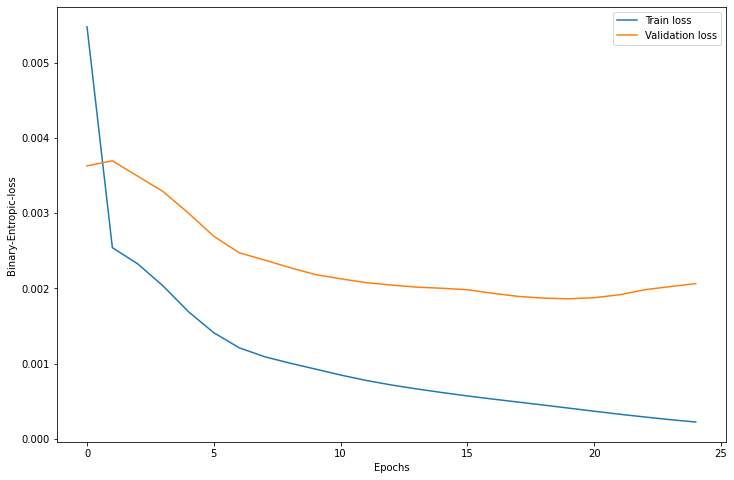

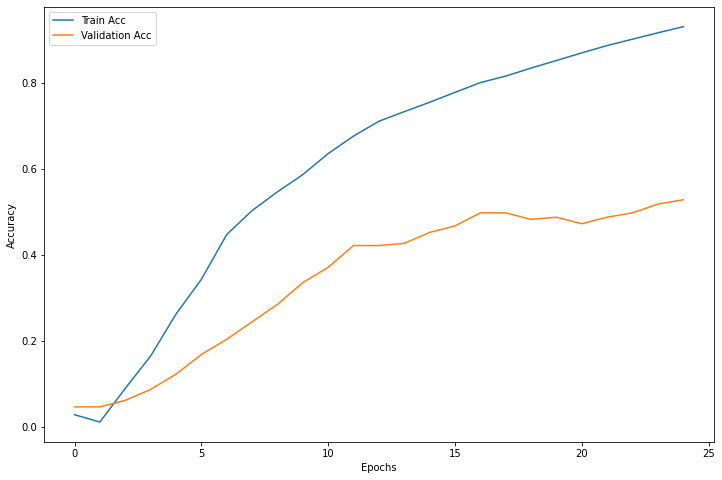

Train Acc: 0.9308056872037914
Validation Acc: 0.5279187817258884


In [231]:
set_seed()
cut_off = 0.5
classification_model_bert = train_classifier(selection="bert", emb_length=768, pred_length=24, batch_size=64, epochs=25, lr=0.001, cut_off=cut_off)

In [232]:
modelsavename = "Phase2_1:bert.pt"
torch.save(classification_model_bert.state_dict(), modelsavename)
# classification_model.load_state_dict(torch.load(modelsavename))

#### Using Pretrained GPT3 Embeddings for Classification
Found that with Batch size = 16, learning Rate = 0.001 & epochs = 25. The Classification model was able to converge without any Overfitting or Noisy gradients update.

Using device: cuda
CUDA is available!  Training on GPU ...


  4%|▍         | 1/25 [00:01<00:28,  1.17s/it]


Epoch: 0, Predicted dist: Counter({1: 9})


  8%|▊         | 2/25 [00:02<00:26,  1.16s/it]


Epoch: 1, Predicted dist: Counter({1: 14})


 12%|█▏        | 3/25 [00:03<00:25,  1.16s/it]


Epoch: 2, Predicted dist: Counter({1: 26})


 16%|█▌        | 4/25 [00:04<00:24,  1.15s/it]


Epoch: 3, Predicted dist: Counter({1: 29, 2: 1})


 20%|██        | 5/25 [00:05<00:23,  1.15s/it]


Epoch: 4, Predicted dist: Counter({1: 27, 2: 1})


 24%|██▍       | 6/25 [00:06<00:21,  1.15s/it]


Epoch: 5, Predicted dist: Counter({1: 36})


 28%|██▊       | 7/25 [00:08<00:20,  1.15s/it]


Epoch: 6, Predicted dist: Counter({1: 37})


 32%|███▏      | 8/25 [00:09<00:19,  1.15s/it]


Epoch: 7, Predicted dist: Counter({1: 44, 2: 3})


 36%|███▌      | 9/25 [00:10<00:18,  1.15s/it]


Epoch: 8, Predicted dist: Counter({1: 44, 2: 2})


 40%|████      | 10/25 [00:11<00:17,  1.15s/it]


Epoch: 9, Predicted dist: Counter({1: 49, 2: 3})


 44%|████▍     | 11/25 [00:12<00:16,  1.14s/it]


Epoch: 10, Predicted dist: Counter({1: 54, 2: 2})


 48%|████▊     | 12/25 [00:13<00:14,  1.15s/it]


Epoch: 11, Predicted dist: Counter({1: 60, 2: 2})


 52%|█████▏    | 13/25 [00:14<00:13,  1.14s/it]


Epoch: 12, Predicted dist: Counter({1: 63, 2: 2})


 56%|█████▌    | 14/25 [00:16<00:12,  1.14s/it]


Epoch: 13, Predicted dist: Counter({1: 70})


 60%|██████    | 15/25 [00:17<00:11,  1.14s/it]


Epoch: 14, Predicted dist: Counter({1: 73, 2: 2})


 64%|██████▍   | 16/25 [00:18<00:10,  1.14s/it]


Epoch: 15, Predicted dist: Counter({1: 75, 2: 3})


 68%|██████▊   | 17/25 [00:19<00:09,  1.14s/it]


Epoch: 16, Predicted dist: Counter({1: 77, 2: 1})


 72%|███████▏  | 18/25 [00:20<00:08,  1.14s/it]


Epoch: 17, Predicted dist: Counter({1: 79, 2: 1})


 76%|███████▌  | 19/25 [00:21<00:06,  1.15s/it]


Epoch: 18, Predicted dist: Counter({1: 80, 2: 1})


 80%|████████  | 20/25 [00:22<00:05,  1.14s/it]


Epoch: 19, Predicted dist: Counter({1: 75})


 84%|████████▍ | 21/25 [00:24<00:04,  1.15s/it]


Epoch: 20, Predicted dist: Counter({1: 77, 2: 1})


 88%|████████▊ | 22/25 [00:25<00:03,  1.15s/it]


Epoch: 21, Predicted dist: Counter({1: 68, 2: 1})


 92%|█████████▏| 23/25 [00:26<00:02,  1.15s/it]


Epoch: 22, Predicted dist: Counter({1: 76})


 96%|█████████▌| 24/25 [00:27<00:01,  1.15s/it]


Epoch: 23, Predicted dist: Counter({1: 76, 2: 2})


100%|██████████| 25/25 [00:28<00:00,  1.15s/it]


Epoch: 24, Predicted dist: Counter({1: 85, 2: 1})




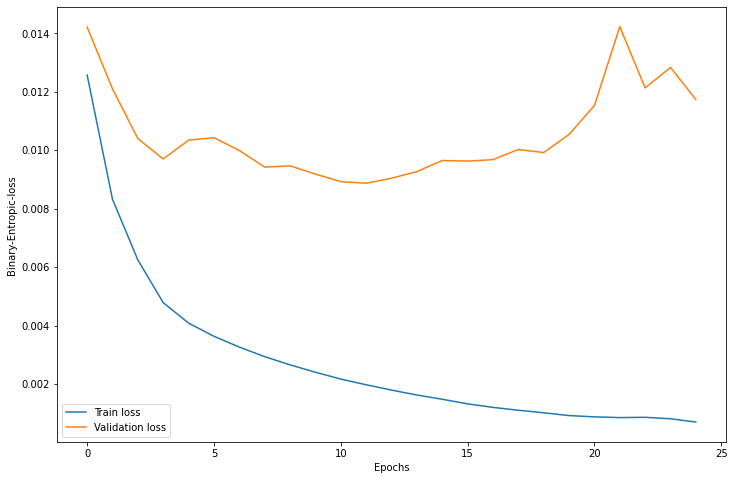

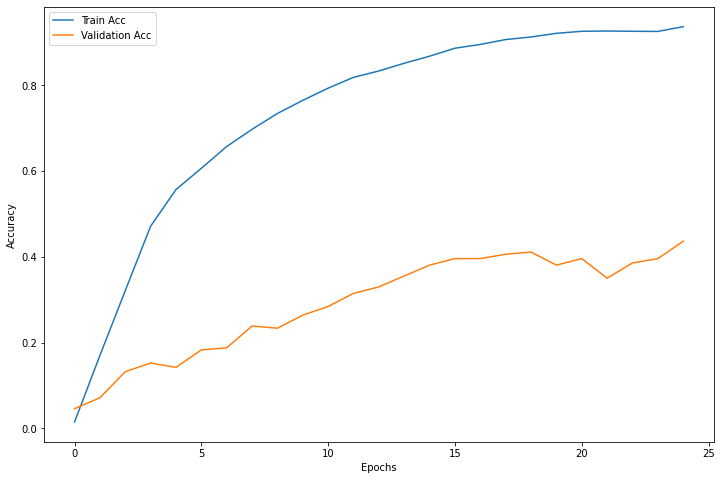

Train Acc: 0.9371248025276462
Validation Acc: 0.4365482233502538


In [233]:
set_seed()
cut_off = 0.5
classification_model_gpt3 = train_classifier(selection="gpt3", emb_length=1024, pred_length=24, batch_size=16, epochs=25, lr=0.001, cut_off=cut_off)

In [234]:
modelsavename = "Phase2_1:gpt3.pt"
torch.save(classification_model_gpt3.state_dict(), modelsavename)

### Experiment 2: Using weights from step 1 and Fine-tunning on hand labeled data

#### Using Pretrained BERT Embeddings for Classification
Found that with Batch size = 64, learning Rate = 0.001 & epochs = 25. The Classification model was able to converge without any Overfitting or Noisy gradients update.

In [235]:
# from collections import Counter
# gics = pd.read_csv("gics_original_ind_group_text_with_embeddings.csv")
# one_hot = MultiLabelBinarizer()
# buff = []
# for each in gics['industry_group']:
#   buff.append([each])
# labels = one_hot.fit_transform(buff)

# gics['labels'] = list(labels)
# display(gics[["text", "labels"]])

# print(labels)
# print(one_hot.classes_)
# gics.to_csv("gics_original_ind_group_text_with_embeddings.csv", index=False)

In [236]:
train_data_1 = pd.read_parquet('dataset_2.parquet')[["text", "labels", "gpt3_ada_embeddings", "bert_mpnet_embeddings"]]
train_data_2 = pd.read_parquet('dataset_3.parquet')[["text", "labels", "gpt3_ada_embeddings", "bert_mpnet_embeddings"]]

train_data = pd.concat([train_data_1, train_data_2])
test_data = pd.read_parquet('dataset_4.parquet')

Using device: cuda
CUDA is available!  Training on GPU ...


  4%|▍         | 1/25 [00:00<00:04,  5.66it/s]


Epoch: 0, Predicted dist: Counter({1: 105, 2: 6})


  8%|▊         | 2/25 [00:00<00:03,  5.78it/s]


Epoch: 1, Predicted dist: Counter({1: 100, 2: 4})


 12%|█▏        | 3/25 [00:00<00:03,  5.91it/s]


Epoch: 2, Predicted dist: Counter({1: 97, 2: 5})


 16%|█▌        | 4/25 [00:00<00:03,  5.90it/s]


Epoch: 3, Predicted dist: Counter({1: 98, 2: 3})


 20%|██        | 5/25 [00:00<00:03,  5.97it/s]


Epoch: 4, Predicted dist: Counter({1: 100, 2: 4})


 24%|██▍       | 6/25 [00:01<00:03,  6.09it/s]


Epoch: 5, Predicted dist: Counter({1: 100, 2: 5})


 28%|██▊       | 7/25 [00:01<00:02,  6.13it/s]


Epoch: 6, Predicted dist: Counter({1: 102, 2: 4})


 32%|███▏      | 8/25 [00:01<00:02,  6.14it/s]


Epoch: 7, Predicted dist: Counter({1: 104, 2: 6})


 36%|███▌      | 9/25 [00:01<00:02,  6.11it/s]


Epoch: 8, Predicted dist: Counter({1: 105, 2: 5})


 40%|████      | 10/25 [00:01<00:02,  6.04it/s]


Epoch: 9, Predicted dist: Counter({1: 104, 2: 5})


 44%|████▍     | 11/25 [00:01<00:02,  6.09it/s]


Epoch: 10, Predicted dist: Counter({1: 106, 2: 6})


 48%|████▊     | 12/25 [00:01<00:02,  6.03it/s]


Epoch: 11, Predicted dist: Counter({1: 107, 2: 6})


 52%|█████▏    | 13/25 [00:02<00:01,  6.05it/s]


Epoch: 12, Predicted dist: Counter({1: 107, 2: 6})


 56%|█████▌    | 14/25 [00:02<00:01,  6.05it/s]


Epoch: 13, Predicted dist: Counter({1: 107, 2: 6})


 60%|██████    | 15/25 [00:02<00:01,  5.96it/s]


Epoch: 14, Predicted dist: Counter({1: 111, 2: 6})


 64%|██████▍   | 16/25 [00:02<00:01,  6.02it/s]


Epoch: 15, Predicted dist: Counter({1: 112, 2: 6})


 68%|██████▊   | 17/25 [00:02<00:01,  6.00it/s]


Epoch: 16, Predicted dist: Counter({1: 112, 2: 6})


 72%|███████▏  | 18/25 [00:02<00:01,  6.03it/s]


Epoch: 17, Predicted dist: Counter({1: 113, 2: 7})


 76%|███████▌  | 19/25 [00:03<00:00,  6.10it/s]


Epoch: 18, Predicted dist: Counter({1: 113, 2: 7})


 80%|████████  | 20/25 [00:03<00:00,  6.14it/s]


Epoch: 19, Predicted dist: Counter({1: 114, 2: 7})


 84%|████████▍ | 21/25 [00:03<00:00,  6.06it/s]


Epoch: 20, Predicted dist: Counter({1: 114, 2: 7})


 88%|████████▊ | 22/25 [00:03<00:00,  6.10it/s]


Epoch: 21, Predicted dist: Counter({1: 116, 2: 7})


 92%|█████████▏| 23/25 [00:03<00:00,  6.08it/s]


Epoch: 22, Predicted dist: Counter({1: 118, 2: 8})


 96%|█████████▌| 24/25 [00:03<00:00,  6.07it/s]


Epoch: 23, Predicted dist: Counter({1: 118, 2: 8})


100%|██████████| 25/25 [00:04<00:00,  6.04it/s]


Epoch: 24, Predicted dist: Counter({1: 118, 2: 8})




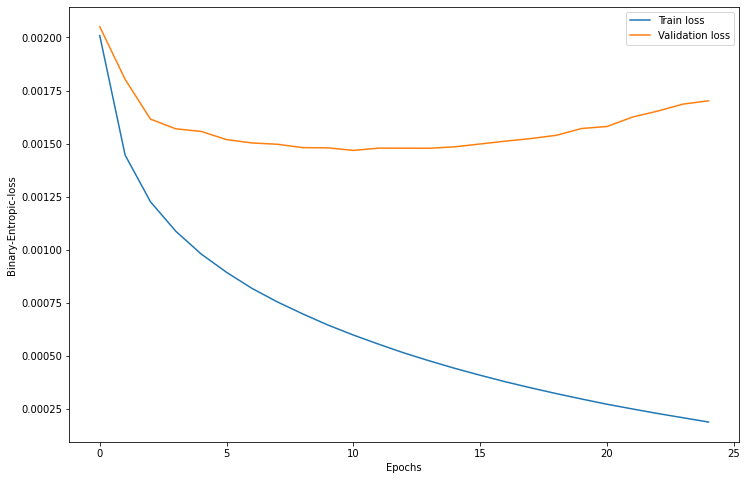

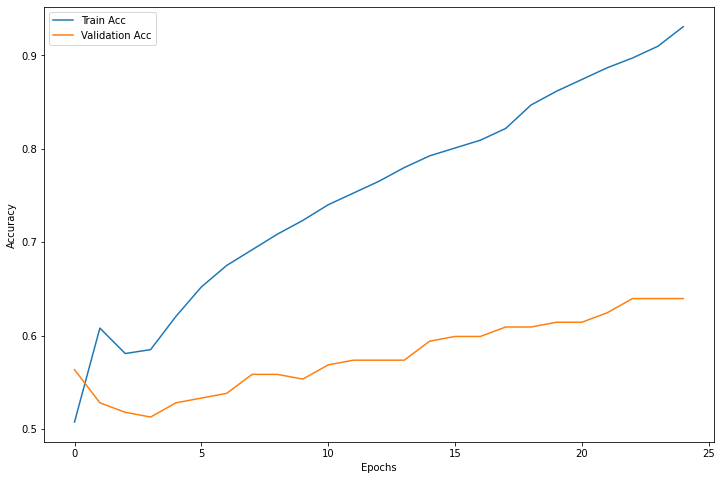

Train Acc: 0.9308176100628931
Validation Acc: 0.6395939086294417


In [237]:
set_seed()
cut_off = 0.65 # best one
classification_model_1 = Industry_Group_Classification_Model(emb_length=768, pred_length=24)
classification_model_1.load_state_dict(torch.load("Phase2_1:bert.pt"))
classification_model_bert = train_classifier(selection="bert", emb_length=768, pred_length=24, batch_size=64, epochs=25, lr=0.001, cut_off=cut_off, load_pretrained=classification_model_1)

0.6:<br>
Train Acc: 0.9350104821802935
Validation Acc: 0.6345177664974619

0.65<br>
Train Acc: 0.9308176100628931
Validation Acc: 0.6395939086294417

0.65 3 layers<br>
Train Acc: 0.7568134171907757
Validation Acc: 0.6142131979695431


In [238]:
modelsavename = "Phase2_2:bert.pt"
torch.save(classification_model_bert.state_dict(), modelsavename)
# classification_model.load_state_dict(torch.load(modelsavename))

#### Using Pretrained GPT3 Embeddings for Classification
Found that with Batch size = 16, learning Rate = 0.001 & epochs = 25. The Classification model was able to converge without any Overfitting or Noisy gradients update.

Using device: cuda
CUDA is available!  Training on GPU ...


  4%|▍         | 1/25 [00:00<00:05,  4.52it/s]


Epoch: 0, Predicted dist: Counter({1: 64, 2: 2})


  8%|▊         | 2/25 [00:00<00:05,  4.26it/s]


Epoch: 1, Predicted dist: Counter({1: 60, 2: 1})


 12%|█▏        | 3/25 [00:00<00:05,  4.40it/s]


Epoch: 2, Predicted dist: Counter({1: 62, 2: 1})


 16%|█▌        | 4/25 [00:00<00:04,  4.46it/s]


Epoch: 3, Predicted dist: Counter({1: 67, 2: 4})


 20%|██        | 5/25 [00:01<00:04,  4.45it/s]


Epoch: 4, Predicted dist: Counter({1: 73, 2: 5})


 24%|██▍       | 6/25 [00:01<00:04,  4.32it/s]


Epoch: 5, Predicted dist: Counter({1: 67, 2: 4})


 28%|██▊       | 7/25 [00:01<00:04,  4.40it/s]


Epoch: 6, Predicted dist: Counter({1: 69, 2: 5})


 32%|███▏      | 8/25 [00:01<00:03,  4.43it/s]


Epoch: 7, Predicted dist: Counter({1: 74, 2: 5})


 36%|███▌      | 9/25 [00:02<00:03,  4.43it/s]


Epoch: 8, Predicted dist: Counter({1: 75, 2: 4})


 40%|████      | 10/25 [00:02<00:03,  4.47it/s]


Epoch: 9, Predicted dist: Counter({1: 72, 2: 2})


 44%|████▍     | 11/25 [00:02<00:03,  4.51it/s]


Epoch: 10, Predicted dist: Counter({1: 71, 2: 2})


 48%|████▊     | 12/25 [00:02<00:02,  4.51it/s]


Epoch: 11, Predicted dist: Counter({1: 69, 2: 3})


 52%|█████▏    | 13/25 [00:02<00:02,  4.51it/s]


Epoch: 12, Predicted dist: Counter({1: 67, 2: 3})


 56%|█████▌    | 14/25 [00:03<00:02,  4.51it/s]


Epoch: 13, Predicted dist: Counter({1: 71, 2: 6})


 60%|██████    | 15/25 [00:03<00:02,  4.54it/s]


Epoch: 14, Predicted dist: Counter({1: 88, 2: 3})


 64%|██████▍   | 16/25 [00:03<00:01,  4.55it/s]


Epoch: 15, Predicted dist: Counter({1: 98, 2: 9})


 68%|██████▊   | 17/25 [00:03<00:01,  4.54it/s]


Epoch: 16, Predicted dist: Counter({1: 96, 2: 4})


 72%|███████▏  | 18/25 [00:04<00:01,  4.43it/s]


Epoch: 17, Predicted dist: Counter({1: 80, 2: 5})


 76%|███████▌  | 19/25 [00:04<00:01,  4.44it/s]


Epoch: 18, Predicted dist: Counter({1: 87, 2: 5})


 80%|████████  | 20/25 [00:04<00:01,  4.47it/s]


Epoch: 19, Predicted dist: Counter({1: 92, 2: 6})


 84%|████████▍ | 21/25 [00:04<00:00,  4.51it/s]


Epoch: 20, Predicted dist: Counter({1: 95, 2: 4})


 88%|████████▊ | 22/25 [00:04<00:00,  4.53it/s]


Epoch: 21, Predicted dist: Counter({1: 97, 2: 5})


 92%|█████████▏| 23/25 [00:05<00:00,  4.52it/s]


Epoch: 22, Predicted dist: Counter({1: 92, 2: 7})


 96%|█████████▌| 24/25 [00:05<00:00,  4.56it/s]


Epoch: 23, Predicted dist: Counter({1: 89, 2: 8})


100%|██████████| 25/25 [00:05<00:00,  4.47it/s]


Epoch: 24, Predicted dist: Counter({1: 88, 2: 7})




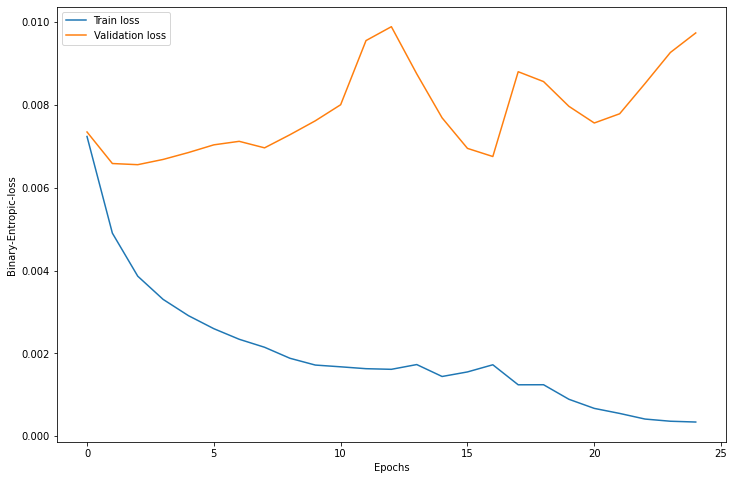

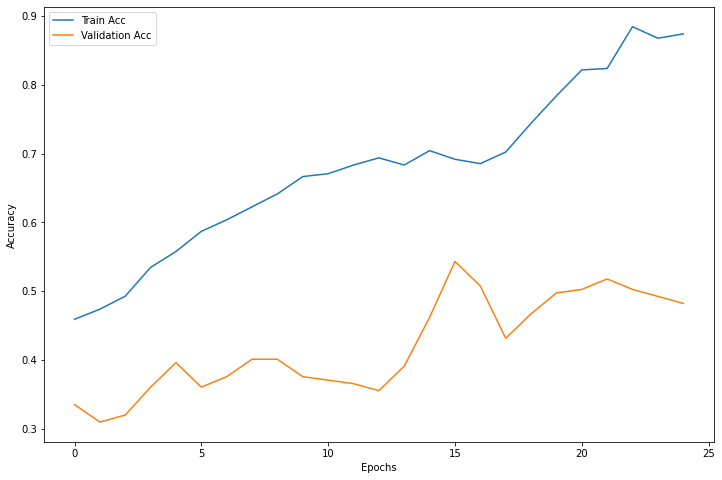

Train Acc: 0.8742138364779874
Validation Acc: 0.48223350253807107


In [239]:
set_seed()
cut_off = 0.9
classification_model_2 = Industry_Group_Classification_Model(emb_length=1024, pred_length=24)
classification_model_2.load_state_dict(torch.load("Phase2_1:gpt3.pt"))
classification_model_gpt3 = train_classifier(selection="gpt3", emb_length=1024, pred_length=24, batch_size=16, epochs=25, lr=0.001, cut_off=cut_off, load_pretrained=classification_model_2)

0.65 4layers<br>
Train Acc: 0.9538784067085954
Validation Acc: 0.45685279187817257

0.65 3 layers <br>
Train Acc: 0.89937106918239
Validation Acc: 0.5482233502538071

0.8 4layers<br>
Train Acc: 0.9266247379454927
Validation Acc: 0.48223350253807107

In [240]:
modelsavename = "Phase2_2:gpt3.pt"
torch.save(classification_model_gpt3.state_dict(), modelsavename)

### Experiment 3: Training model with complete data

#### Using Pretrained BERT Embeddings for Classification
Found that with Batch size = 64, learning Rate = 0.001 & epochs = 25. The Classification model was able to converge without any Overfitting or Noisy gradients update.

In [241]:
train_data_1 = pd.read_parquet('dataset_1.parquet')[["text", "labels", "gpt3_ada_embeddings", "bert_mpnet_embeddings"]]
train_data_2 = pd.read_parquet('dataset_2.parquet')[["text", "labels", "gpt3_ada_embeddings", "bert_mpnet_embeddings"]]
train_data_3 = pd.read_parquet('dataset_3.parquet')[["text", "labels", "gpt3_ada_embeddings", "bert_mpnet_embeddings"]]

train_data = pd.concat([train_data_1, train_data_2, train_data_3])
test_data = pd.read_parquet('dataset_4.parquet')

Using device: cuda
CUDA is available!  Training on GPU ...


  4%|▍         | 1/25 [00:00<00:21,  1.11it/s]


Epoch: 0, Predicted dist: Counter({1: 9})


  8%|▊         | 2/25 [00:01<00:20,  1.10it/s]


Epoch: 1, Predicted dist: Counter({1: 9})


 12%|█▏        | 3/25 [00:02<00:20,  1.09it/s]


Epoch: 2, Predicted dist: Counter({1: 12})


 16%|█▌        | 4/25 [00:03<00:19,  1.07it/s]


Epoch: 3, Predicted dist: Counter({1: 16})


 20%|██        | 5/25 [00:04<00:18,  1.08it/s]


Epoch: 4, Predicted dist: Counter({1: 24})


 24%|██▍       | 6/25 [00:05<00:17,  1.08it/s]


Epoch: 5, Predicted dist: Counter({1: 37, 2: 4})


 28%|██▊       | 7/25 [00:06<00:16,  1.09it/s]


Epoch: 6, Predicted dist: Counter({1: 52, 2: 6})


 32%|███▏      | 8/25 [00:07<00:15,  1.09it/s]


Epoch: 7, Predicted dist: Counter({1: 60, 2: 4})


 36%|███▌      | 9/25 [00:08<00:14,  1.10it/s]


Epoch: 8, Predicted dist: Counter({1: 69, 2: 4})


 40%|████      | 10/25 [00:09<00:13,  1.10it/s]


Epoch: 9, Predicted dist: Counter({1: 73, 2: 4})


 44%|████▍     | 11/25 [00:10<00:12,  1.10it/s]


Epoch: 10, Predicted dist: Counter({1: 81, 2: 5})


 48%|████▊     | 12/25 [00:10<00:11,  1.10it/s]


Epoch: 11, Predicted dist: Counter({1: 86, 2: 5})


 52%|█████▏    | 13/25 [00:11<00:10,  1.10it/s]


Epoch: 12, Predicted dist: Counter({1: 89, 2: 6})


 56%|█████▌    | 14/25 [00:12<00:09,  1.10it/s]


Epoch: 13, Predicted dist: Counter({1: 94, 2: 6})


 60%|██████    | 15/25 [00:13<00:09,  1.09it/s]


Epoch: 14, Predicted dist: Counter({1: 97, 2: 5})


 64%|██████▍   | 16/25 [00:14<00:08,  1.10it/s]


Epoch: 15, Predicted dist: Counter({1: 99, 2: 7})


 68%|██████▊   | 17/25 [00:15<00:07,  1.10it/s]


Epoch: 16, Predicted dist: Counter({1: 100, 2: 6})


 72%|███████▏  | 18/25 [00:16<00:06,  1.10it/s]


Epoch: 17, Predicted dist: Counter({1: 102, 2: 6})


 76%|███████▌  | 19/25 [00:17<00:05,  1.10it/s]


Epoch: 18, Predicted dist: Counter({1: 105, 2: 7})


 80%|████████  | 20/25 [00:18<00:04,  1.09it/s]


Epoch: 19, Predicted dist: Counter({1: 110, 2: 8})


 84%|████████▍ | 21/25 [00:19<00:03,  1.09it/s]


Epoch: 20, Predicted dist: Counter({1: 110, 2: 10})


 88%|████████▊ | 22/25 [00:20<00:02,  1.10it/s]


Epoch: 21, Predicted dist: Counter({1: 110, 2: 8})


 92%|█████████▏| 23/25 [00:21<00:01,  1.10it/s]


Epoch: 22, Predicted dist: Counter({1: 110, 2: 6})


 96%|█████████▌| 24/25 [00:21<00:00,  1.08it/s]


Epoch: 23, Predicted dist: Counter({1: 113, 2: 5})


100%|██████████| 25/25 [00:22<00:00,  1.09it/s]


Epoch: 24, Predicted dist: Counter({1: 110, 2: 7})




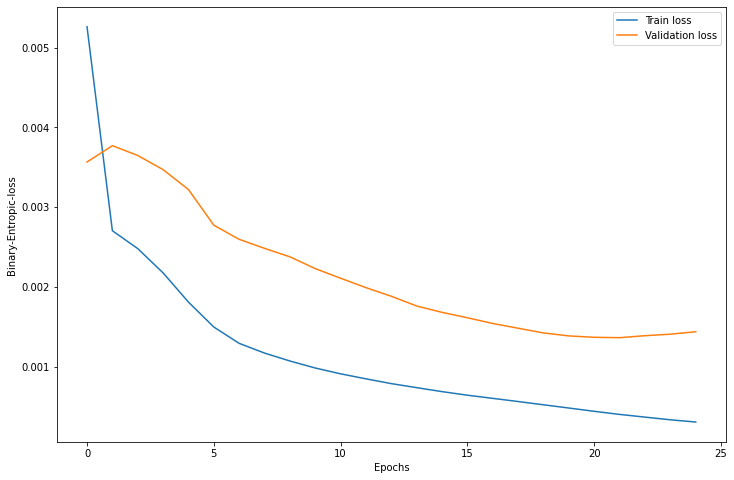

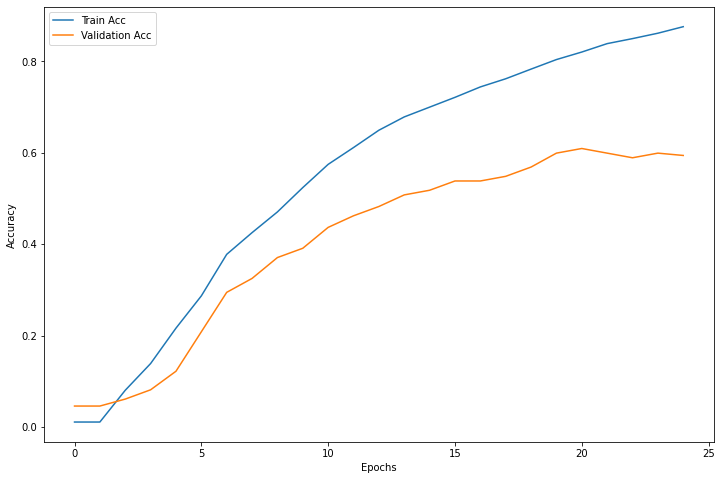

Train Acc: 0.8756177924217463
Validation Acc: 0.5939086294416244


In [242]:
set_seed()
cut_off = 0.6
classification_model_bert = train_classifier(selection="bert", emb_length=768, pred_length=24, batch_size=64, epochs=25, lr=0.001, cut_off=cut_off)

In [243]:
modelsavename = "Phase2_3:bert.pt"
torch.save(classification_model_bert.state_dict(), modelsavename)
# classification_model.load_state_dict(torch.load(modelsavename))

#### Using Pretrained GPT3 Embeddings for Classification
Found that with Batch size = 16, learning Rate = 0.001 & epochs = 25. The Classification model was able to converge without any Overfitting or Noisy gradients update.

Using device: cuda
CUDA is available!  Training on GPU ...


  4%|▍         | 1/25 [00:01<00:31,  1.31s/it]


Epoch: 0, Predicted dist: Counter({1: 9})


  8%|▊         | 2/25 [00:02<00:30,  1.31s/it]


Epoch: 1, Predicted dist: Counter({1: 10})


 12%|█▏        | 3/25 [00:03<00:28,  1.30s/it]


Epoch: 2, Predicted dist: Counter({1: 9})


 16%|█▌        | 4/25 [00:05<00:27,  1.31s/it]


Epoch: 3, Predicted dist: Counter({1: 11})


 20%|██        | 5/25 [00:06<00:26,  1.30s/it]


Epoch: 4, Predicted dist: Counter({1: 12})


 24%|██▍       | 6/25 [00:07<00:24,  1.30s/it]


Epoch: 5, Predicted dist: Counter({1: 14})


 28%|██▊       | 7/25 [00:09<00:23,  1.31s/it]


Epoch: 6, Predicted dist: Counter({1: 22})


 32%|███▏      | 8/25 [00:10<00:22,  1.31s/it]


Epoch: 7, Predicted dist: Counter({1: 23})


 36%|███▌      | 9/25 [00:11<00:20,  1.31s/it]


Epoch: 8, Predicted dist: Counter({1: 30})


 40%|████      | 10/25 [00:13<00:19,  1.31s/it]


Epoch: 9, Predicted dist: Counter({1: 35})


 44%|████▍     | 11/25 [00:14<00:18,  1.32s/it]


Epoch: 10, Predicted dist: Counter({1: 37})


 48%|████▊     | 12/25 [00:15<00:17,  1.32s/it]


Epoch: 11, Predicted dist: Counter({1: 47})


 52%|█████▏    | 13/25 [00:17<00:15,  1.32s/it]


Epoch: 12, Predicted dist: Counter({1: 61})


 56%|█████▌    | 14/25 [00:18<00:14,  1.32s/it]


Epoch: 13, Predicted dist: Counter({1: 59})


 60%|██████    | 15/25 [00:19<00:13,  1.32s/it]


Epoch: 14, Predicted dist: Counter({1: 59})


 64%|██████▍   | 16/25 [00:21<00:11,  1.32s/it]


Epoch: 15, Predicted dist: Counter({1: 71})


 68%|██████▊   | 17/25 [00:22<00:10,  1.32s/it]


Epoch: 16, Predicted dist: Counter({1: 73})


 72%|███████▏  | 18/25 [00:23<00:09,  1.31s/it]


Epoch: 17, Predicted dist: Counter({1: 63})


 76%|███████▌  | 19/25 [00:24<00:07,  1.31s/it]


Epoch: 18, Predicted dist: Counter({1: 66, 2: 2})


 80%|████████  | 20/25 [00:26<00:06,  1.31s/it]


Epoch: 19, Predicted dist: Counter({1: 80, 2: 2})


 84%|████████▍ | 21/25 [00:27<00:05,  1.31s/it]


Epoch: 20, Predicted dist: Counter({1: 85, 2: 3})


 88%|████████▊ | 22/25 [00:28<00:03,  1.30s/it]


Epoch: 21, Predicted dist: Counter({1: 71, 2: 3})


 92%|█████████▏| 23/25 [00:30<00:02,  1.31s/it]


Epoch: 22, Predicted dist: Counter({1: 65, 2: 3})


 96%|█████████▌| 24/25 [00:31<00:01,  1.31s/it]


Epoch: 23, Predicted dist: Counter({1: 64})


100%|██████████| 25/25 [00:32<00:00,  1.31s/it]


Epoch: 24, Predicted dist: Counter({1: 71, 2: 4})




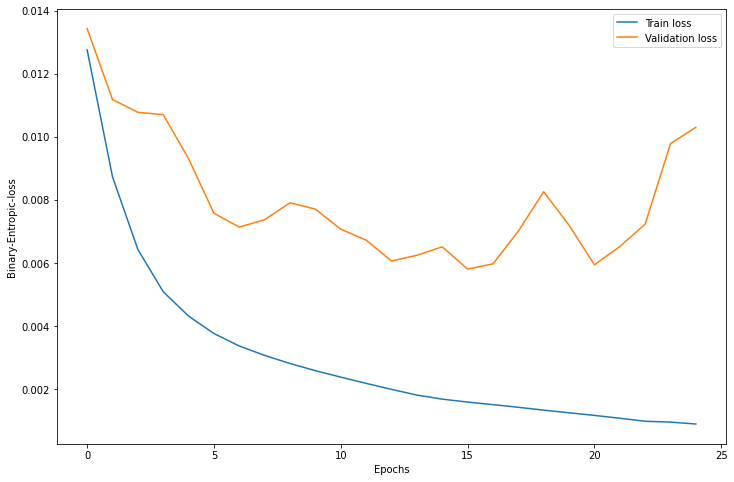

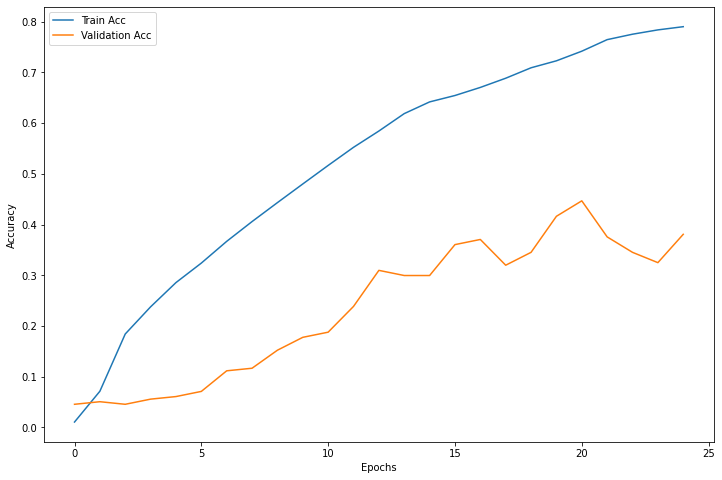

Train Acc: 0.7899505766062603
Validation Acc: 0.38071065989847713


In [244]:
set_seed()
cut_off = 0.9
classification_model_gpt3 = train_classifier(selection="gpt3", emb_length=1024, pred_length=24, batch_size=16, epochs=25, lr=0.001, cut_off=cut_off)

In [245]:
modelsavename = "Phase2_3:gpt3.pt"
torch.save(classification_model_gpt3.state_dict(), modelsavename)

### Experiment 4: Training model only with multi labeled data

#### Using Pretrained BERT Embeddings for Classification
Found that with Batch size = 64, learning Rate = 0.001 & epochs = 25. The Classification model was able to converge without any Overfitting or Noisy gradients update.

In [246]:
train_data_1 = pd.read_parquet('dataset_2.parquet')[["text", "labels", "gpt3_ada_embeddings", "bert_mpnet_embeddings"]]
train_data_2 = pd.read_parquet('dataset_3.parquet')[["text", "labels", "gpt3_ada_embeddings", "bert_mpnet_embeddings"]]

train_data = pd.concat([train_data_1, train_data_2])
test_data = pd.read_parquet('dataset_4.parquet')

Using device: cuda
CUDA is available!  Training on GPU ...


  4%|▍         | 1/25 [00:00<00:04,  5.88it/s]


Epoch: 0, Predicted dist: Counter({1: 9})


  8%|▊         | 2/25 [00:00<00:03,  5.86it/s]


Epoch: 1, Predicted dist: Counter({1: 5})


 12%|█▏        | 3/25 [00:00<00:03,  6.05it/s]


Epoch: 2, Predicted dist: Counter({1: 6})


 16%|█▌        | 4/25 [00:00<00:03,  6.08it/s]


Epoch: 3, Predicted dist: Counter({1: 9})


 20%|██        | 5/25 [00:00<00:03,  6.12it/s]


Epoch: 4, Predicted dist: Counter({1: 9})


 24%|██▍       | 6/25 [00:00<00:03,  6.16it/s]


Epoch: 5, Predicted dist: Counter({1: 9})


 28%|██▊       | 7/25 [00:01<00:02,  6.13it/s]


Epoch: 6, Predicted dist: Counter({1: 9})


 32%|███▏      | 8/25 [00:01<00:02,  6.09it/s]


Epoch: 7, Predicted dist: Counter({1: 9})


 36%|███▌      | 9/25 [00:01<00:02,  6.13it/s]


Epoch: 8, Predicted dist: Counter({1: 9})


 40%|████      | 10/25 [00:01<00:02,  6.15it/s]


Epoch: 9, Predicted dist: Counter({1: 9})


 44%|████▍     | 11/25 [00:01<00:02,  6.21it/s]


Epoch: 10, Predicted dist: Counter({1: 9})


 48%|████▊     | 12/25 [00:01<00:02,  6.20it/s]


Epoch: 11, Predicted dist: Counter({1: 9})


 52%|█████▏    | 13/25 [00:02<00:01,  6.27it/s]


Epoch: 12, Predicted dist: Counter({1: 9})


 56%|█████▌    | 14/25 [00:02<00:01,  6.22it/s]


Epoch: 13, Predicted dist: Counter({1: 9})


 60%|██████    | 15/25 [00:02<00:01,  6.25it/s]


Epoch: 14, Predicted dist: Counter({1: 9})


 64%|██████▍   | 16/25 [00:02<00:01,  6.26it/s]


Epoch: 15, Predicted dist: Counter({1: 9})


 68%|██████▊   | 17/25 [00:02<00:01,  6.28it/s]


Epoch: 16, Predicted dist: Counter({1: 9})


 72%|███████▏  | 18/25 [00:02<00:01,  6.24it/s]


Epoch: 17, Predicted dist: Counter({1: 9})


 76%|███████▌  | 19/25 [00:03<00:00,  6.28it/s]


Epoch: 18, Predicted dist: Counter({1: 9})


 80%|████████  | 20/25 [00:03<00:00,  6.21it/s]


Epoch: 19, Predicted dist: Counter({1: 9})


 84%|████████▍ | 21/25 [00:03<00:00,  6.21it/s]


Epoch: 20, Predicted dist: Counter({1: 9})


 88%|████████▊ | 22/25 [00:03<00:00,  6.19it/s]


Epoch: 21, Predicted dist: Counter({1: 9})


 92%|█████████▏| 23/25 [00:03<00:00,  6.18it/s]


Epoch: 22, Predicted dist: Counter({1: 11})


 96%|█████████▌| 24/25 [00:03<00:00,  6.17it/s]


Epoch: 23, Predicted dist: Counter({1: 18})


100%|██████████| 25/25 [00:04<00:00,  6.18it/s]


Epoch: 24, Predicted dist: Counter({1: 22, 2: 1})




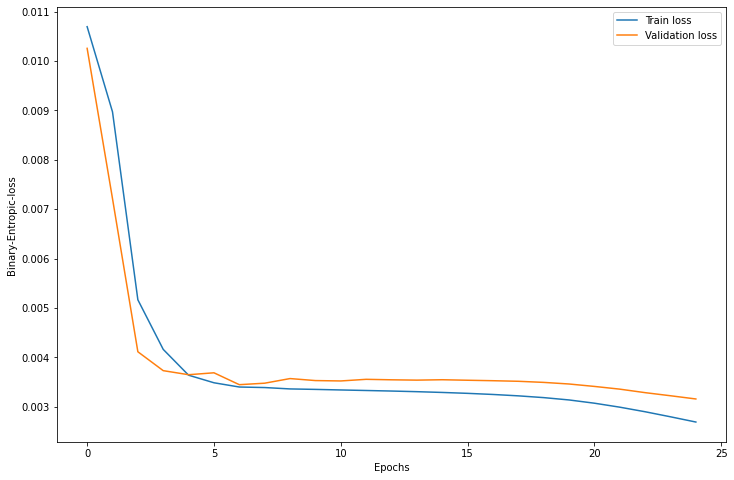

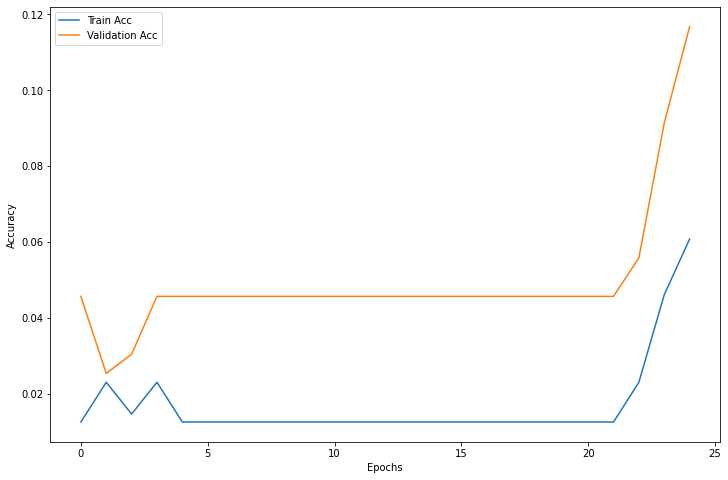

Train Acc: 0.06079664570230608
Validation Acc: 0.116751269035533


In [247]:
set_seed()
cut_off = 0.4
classification_model_bert = train_classifier(selection="bert", emb_length=768, pred_length=24, batch_size=64, epochs=25, lr=0.001, cut_off=cut_off)

In [248]:
modelsavename = "Phase2_4:bert.pt"
torch.save(classification_model_bert.state_dict(), modelsavename)
# classification_model.load_state_dict(torch.load(modelsavename))

#### Using Pretrained GPT3 Embeddings for Classification
Found that with Batch size = 16, learning Rate = 0.001 & epochs = 25. The Classification model was able to converge without any Overfitting or Noisy gradients update.

Using device: cuda
CUDA is available!  Training on GPU ...


  4%|▍         | 1/25 [00:00<00:05,  4.55it/s]


Epoch: 0, Predicted dist: Counter({1: 9})


  8%|▊         | 2/25 [00:00<00:05,  4.53it/s]


Epoch: 1, Predicted dist: Counter({1: 9})


 12%|█▏        | 3/25 [00:00<00:04,  4.47it/s]


Epoch: 2, Predicted dist: Counter({1: 9})


 16%|█▌        | 4/25 [00:00<00:04,  4.50it/s]


Epoch: 3, Predicted dist: Counter({1: 9})


 20%|██        | 5/25 [00:01<00:04,  4.49it/s]


Epoch: 4, Predicted dist: Counter({1: 9})


 24%|██▍       | 6/25 [00:01<00:04,  4.52it/s]


Epoch: 5, Predicted dist: Counter({1: 9})


 28%|██▊       | 7/25 [00:01<00:03,  4.55it/s]


Epoch: 6, Predicted dist: Counter({1: 9})


 32%|███▏      | 8/25 [00:01<00:03,  4.57it/s]


Epoch: 7, Predicted dist: Counter({1: 9})


 36%|███▌      | 9/25 [00:01<00:03,  4.48it/s]


Epoch: 8, Predicted dist: Counter({1: 9})


 40%|████      | 10/25 [00:02<00:03,  4.50it/s]


Epoch: 9, Predicted dist: Counter({1: 9})


 44%|████▍     | 11/25 [00:02<00:03,  4.49it/s]


Epoch: 10, Predicted dist: Counter({1: 9})


 48%|████▊     | 12/25 [00:02<00:02,  4.51it/s]


Epoch: 11, Predicted dist: Counter({1: 9})


 52%|█████▏    | 13/25 [00:02<00:02,  4.51it/s]


Epoch: 12, Predicted dist: Counter({1: 9})


 56%|█████▌    | 14/25 [00:03<00:02,  4.49it/s]


Epoch: 13, Predicted dist: Counter({1: 9})


 60%|██████    | 15/25 [00:03<00:02,  4.51it/s]


Epoch: 14, Predicted dist: Counter({1: 12})


 64%|██████▍   | 16/25 [00:03<00:01,  4.57it/s]


Epoch: 15, Predicted dist: Counter({1: 19})


 68%|██████▊   | 17/25 [00:03<00:01,  4.57it/s]


Epoch: 16, Predicted dist: Counter({1: 15})


 72%|███████▏  | 18/25 [00:03<00:01,  4.53it/s]


Epoch: 17, Predicted dist: Counter({1: 21, 2: 2})


 76%|███████▌  | 19/25 [00:04<00:01,  4.52it/s]


Epoch: 18, Predicted dist: Counter({1: 21, 2: 6})


 80%|████████  | 20/25 [00:04<00:01,  4.50it/s]


Epoch: 19, Predicted dist: Counter({1: 18, 2: 1})


 84%|████████▍ | 21/25 [00:04<00:00,  4.50it/s]


Epoch: 20, Predicted dist: Counter({1: 21, 2: 1})


 88%|████████▊ | 22/25 [00:04<00:00,  4.50it/s]


Epoch: 21, Predicted dist: Counter({1: 27, 2: 2})


 92%|█████████▏| 23/25 [00:05<00:00,  4.50it/s]


Epoch: 22, Predicted dist: Counter({1: 34, 2: 2})


 96%|█████████▌| 24/25 [00:05<00:00,  4.51it/s]


Epoch: 23, Predicted dist: Counter({1: 43, 2: 2})


100%|██████████| 25/25 [00:05<00:00,  4.51it/s]


Epoch: 24, Predicted dist: Counter({1: 51, 2: 2})




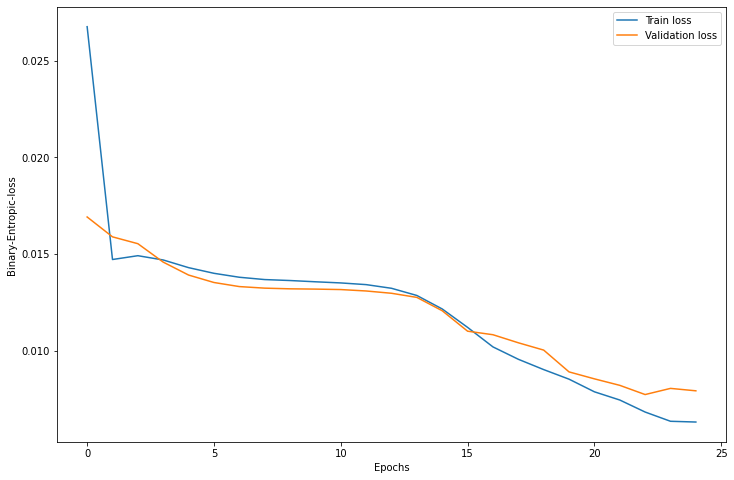

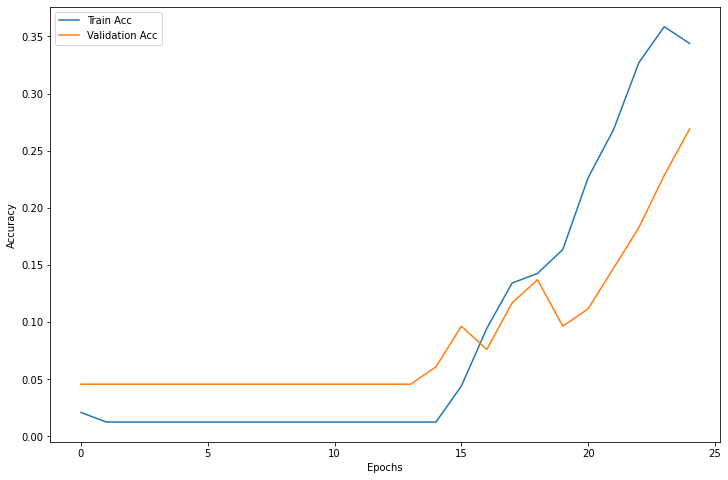

Train Acc: 0.3438155136268344
Validation Acc: 0.26903553299492383


In [249]:
set_seed()
cut_off = 0.5
classification_model_gpt3 = train_classifier(selection="gpt3", emb_length=1024, pred_length=24, batch_size=16, epochs=25, lr=0.001, cut_off=cut_off)

In [250]:
modelsavename = "Phase2_4:gpt3.pt"
torch.save(classification_model_gpt3.state_dict(), modelsavename)

### Test Verifications
1. Model trained on only single labeled data
2. Model trained on multi-hand labeled data, with pre-trained single labeled weigths.
3. Model trained on complete data
4. Model only trained on multi-hand labeled data

##### BERT Verifications

In [251]:
## trained on single label data
from sklearn.metrics import classification_report, accuracy_score

labels = ['Automobiles & Components','Banks','Capital Goods',
 'Commercial & Professional Services','Consumer Durables & Apparel',
 'Consumer Services','Diversified Financials','Energy',
 'Food & Staples Retailing','Food, Beverage & Tobacco',
 'Health Care Equipment & Services','Household & Personal Products',
 'Insurance','Materials','Media & Entertainment',
 'Pharmaceuticals, Biotechnology & Life Sciences','Real Estate',
 'Retailing','Semiconductors & Semiconductor Equipment',
 'Software & Services','Technology Hardware & Equipment',
 'Telecommunication Services','Transportation','Utilities']


cut_off = 0.5
set_seed()
classification_model_loaded = Industry_Group_Classification_Model(emb_length=768, pred_length=24)
classification_model_loaded.load_state_dict(torch.load("Phase2_1:bert.pt"))
classification_model_loaded = classification_model_loaded.cuda()

test_data = pd.read_parquet('dataset_4.parquet')
y = torch.tensor(list(test_data["labels"]))

classification_model_loaded.eval()
with torch.no_grad():

  pred = classification_model_loaded(list(test_data["bert_mpnet_embeddings"]))

  ## For one-hot accuracy calculation
  outputs = torch.sigmoid(pred)

  y_pred = (outputs > cut_off).float()
  y_pred = y_pred.cpu()
  
# print(classification_report(y_target,y_pred_out,output_dict=False,target_names=class_labels))
scores = classification_report(y, y_pred, output_dict=True, target_names=labels, zero_division=0)
accys = accuracy_score(y, y_pred)

display(pd.DataFrame(scores).transpose())

print("Test Accuracy (avg):", accys)
print("Test F1 (micro avg) Scores:", (scores['micro avg']['f1-score']))

,precision,recall,f1-score,support
Automobiles & Components,1.000000,0.285714,0.444444,14.0
Banks,0.900000,0.818182,0.857143,11.0
Capital Goods,0.615385,0.615385,0.615385,13.0
Commercial & Professional Services,0.666667,0.400000,0.500000,10.0
Consumer Durables & Apparel,1.000000,0.555556,0.714286,9.0
Consumer Services,0.750000,0.500000,0.600000,6.0
Diversified Financials,0.846154,0.647059,0.733333,17.0
Energy,0.500000,1.000000,0.666667,7.0
Food & Staples Retailing,1.000000,0.600000,0.750000,5.0
"Food, Beverage & Tobacco",0.857143,0.857143,0.857143,14.0


Test Accuracy (avg): 0.4517766497461929
Test F1 (micro avg) Scores: 0.6222222222222222


In [252]:
## trained on single label data then finetunned with hand labeled
from sklearn.metrics import classification_report, accuracy_score

labels = ['Automobiles & Components','Banks','Capital Goods',
 'Commercial & Professional Services','Consumer Durables & Apparel',
 'Consumer Services','Diversified Financials','Energy',
 'Food & Staples Retailing','Food, Beverage & Tobacco',
 'Health Care Equipment & Services','Household & Personal Products',
 'Insurance','Materials','Media & Entertainment',
 'Pharmaceuticals, Biotechnology & Life Sciences','Real Estate',
 'Retailing','Semiconductors & Semiconductor Equipment',
 'Software & Services','Technology Hardware & Equipment',
 'Telecommunication Services','Transportation','Utilities']


cut_off = 0.65
set_seed()
classification_model_loaded = Industry_Group_Classification_Model(emb_length=768, pred_length=24)
classification_model_loaded.load_state_dict(torch.load("Phase2_2:bert.pt"))
classification_model_loaded = classification_model_loaded.cuda()

test_data = pd.read_parquet('dataset_4.parquet')
y = torch.tensor(list(test_data["labels"]))

classification_model_loaded.eval()
with torch.no_grad():

  pred = classification_model_loaded(list(test_data["bert_mpnet_embeddings"]))

  ## For one-hot accuracy calculation
  outputs = torch.sigmoid(pred)

  y_pred = (outputs > cut_off).float()
  y_pred = y_pred.cpu()
  
# print(classification_report(y_target,y_pred_out,output_dict=False,target_names=class_labels))
scores = classification_report(y, y_pred, output_dict=True, target_names=labels, zero_division=0)
accys = accuracy_score(y, y_pred)

display(pd.DataFrame(scores).transpose())

print("Test Accuracy (avg):", accys)
print("Test F1 (micro avg) Scores:", (scores['micro avg']['f1-score']))

,precision,recall,f1-score,support
Automobiles & Components,1.000000,0.785714,0.880000,14.0
Banks,0.888889,0.727273,0.800000,11.0
Capital Goods,0.705882,0.923077,0.800000,13.0
Commercial & Professional Services,0.357143,0.500000,0.416667,10.0
Consumer Durables & Apparel,0.857143,0.666667,0.750000,9.0
Consumer Services,0.857143,1.000000,0.923077,6.0
Diversified Financials,0.800000,0.705882,0.750000,17.0
Energy,0.538462,1.000000,0.700000,7.0
Food & Staples Retailing,0.833333,1.000000,0.909091,5.0
"Food, Beverage & Tobacco",0.857143,0.857143,0.857143,14.0


Test Accuracy (avg): 0.5431472081218274
Test F1 (micro avg) Scores: 0.7137096774193549


0.6:<br>
Test Accuracy (avg): 0.5329949238578681
Test F1 (micro avg) Scores: 0.6996047430830039

0.65<br>
Test Accuracy (avg): 0.5431472081218274
Test F1 (micro avg) Scores: 0.7137096774193549

In [253]:
# trained on complete data
from sklearn.metrics import classification_report, accuracy_score

labels = ['Automobiles & Components','Banks','Capital Goods',
 'Commercial & Professional Services','Consumer Durables & Apparel',
 'Consumer Services','Diversified Financials','Energy',
 'Food & Staples Retailing','Food, Beverage & Tobacco',
 'Health Care Equipment & Services','Household & Personal Products',
 'Insurance','Materials','Media & Entertainment',
 'Pharmaceuticals, Biotechnology & Life Sciences','Real Estate',
 'Retailing','Semiconductors & Semiconductor Equipment',
 'Software & Services','Technology Hardware & Equipment',
 'Telecommunication Services','Transportation','Utilities']


cut_off = 0.60
set_seed()
classification_model_loaded = Industry_Group_Classification_Model(emb_length=768, pred_length=24)
classification_model_loaded.load_state_dict(torch.load("Phase2_3:bert.pt"))
classification_model_loaded = classification_model_loaded.cuda()

test_data = pd.read_parquet('dataset_4.parquet')
y = torch.tensor(list(test_data["labels"]))

classification_model_loaded.eval()
with torch.no_grad():

  pred = classification_model_loaded(list(test_data["bert_mpnet_embeddings"]))

  ## For one-hot accuracy calculation
  outputs = torch.sigmoid(pred)

  y_pred = (outputs > cut_off).float()
  y_pred = y_pred.cpu()
  
# print(classification_report(y_target,y_pred_out,output_dict=False,target_names=class_labels))
scores = classification_report(y, y_pred, output_dict=True, target_names=labels, zero_division=0)
accys = accuracy_score(y, y_pred)

display(pd.DataFrame(scores).transpose())

print("Test Accuracy (avg):", accys)
print("Test F1 (micro avg) Scores:", (scores['micro avg']['f1-score']))

,precision,recall,f1-score,support
Automobiles & Components,1.000000,0.285714,0.444444,14.0
Banks,1.000000,0.636364,0.777778,11.0
Capital Goods,0.900000,0.692308,0.782609,13.0
Commercial & Professional Services,0.500000,0.900000,0.642857,10.0
Consumer Durables & Apparel,1.000000,0.666667,0.800000,9.0
Consumer Services,1.000000,0.666667,0.800000,6.0
Diversified Financials,0.882353,0.882353,0.882353,17.0
Energy,0.538462,1.000000,0.700000,7.0
Food & Staples Retailing,1.000000,1.000000,1.000000,5.0
"Food, Beverage & Tobacco",0.928571,0.928571,0.928571,14.0


Test Accuracy (avg): 0.5126903553299492
Test F1 (micro avg) Scores: 0.7114967462039045


In [254]:
# trained only on hand labeled data
from sklearn.metrics import classification_report, accuracy_score

labels = ['Automobiles & Components','Banks','Capital Goods',
 'Commercial & Professional Services','Consumer Durables & Apparel',
 'Consumer Services','Diversified Financials','Energy',
 'Food & Staples Retailing','Food, Beverage & Tobacco',
 'Health Care Equipment & Services','Household & Personal Products',
 'Insurance','Materials','Media & Entertainment',
 'Pharmaceuticals, Biotechnology & Life Sciences','Real Estate',
 'Retailing','Semiconductors & Semiconductor Equipment',
 'Software & Services','Technology Hardware & Equipment',
 'Telecommunication Services','Transportation','Utilities']


cut_off = 0.4
set_seed()
classification_model_loaded = Industry_Group_Classification_Model(emb_length=768, pred_length=24)
classification_model_loaded.load_state_dict(torch.load("Phase2_4:bert.pt"))
classification_model_loaded = classification_model_loaded.cuda()

test_data = pd.read_parquet('dataset_4.parquet')
y = torch.tensor(list(test_data["labels"]))

classification_model_loaded.eval()
with torch.no_grad():

  pred = classification_model_loaded(list(test_data["bert_mpnet_embeddings"]))

  ## For one-hot accuracy calculation
  outputs = torch.sigmoid(pred)

  y_pred = (outputs > cut_off).float()
  y_pred = y_pred.cpu()
  
# print(classification_report(y_target,y_pred_out,output_dict=False,target_names=class_labels))
scores = classification_report(y, y_pred, output_dict=True, target_names=labels, zero_division=0)
accys = accuracy_score(y, y_pred)

display(pd.DataFrame(scores).transpose())

print("Test Accuracy (avg):", accys)
print("Test F1 (micro avg) Scores:", (scores['micro avg']['f1-score']))

,precision,recall,f1-score,support
Automobiles & Components,0.000000,0.000000,0.000000,14.0
Banks,0.000000,0.000000,0.000000,11.0
Capital Goods,0.000000,0.000000,0.000000,13.0
Commercial & Professional Services,0.000000,0.000000,0.000000,10.0
Consumer Durables & Apparel,0.000000,0.000000,0.000000,9.0
Consumer Services,0.000000,0.000000,0.000000,6.0
Diversified Financials,0.000000,0.000000,0.000000,17.0
Energy,0.466667,1.000000,0.636364,7.0
Food & Staples Retailing,0.000000,0.000000,0.000000,5.0
"Food, Beverage & Tobacco",0.000000,0.000000,0.000000,14.0


Test Accuracy (avg): 0.05583756345177665
Test F1 (micro avg) Scores: 0.19540229885057472


##### GPT3 Verifications

In [255]:
## trained on single label data
from sklearn.metrics import classification_report, accuracy_score

labels = ['Automobiles & Components','Banks','Capital Goods',
 'Commercial & Professional Services','Consumer Durables & Apparel',
 'Consumer Services','Diversified Financials','Energy',
 'Food & Staples Retailing','Food, Beverage & Tobacco',
 'Health Care Equipment & Services','Household & Personal Products',
 'Insurance','Materials','Media & Entertainment',
 'Pharmaceuticals, Biotechnology & Life Sciences','Real Estate',
 'Retailing','Semiconductors & Semiconductor Equipment',
 'Software & Services','Technology Hardware & Equipment',
 'Telecommunication Services','Transportation','Utilities']

cut_off = 0.5
set_seed()
classification_model_loaded = Industry_Group_Classification_Model(emb_length=1024, pred_length=24)
classification_model_loaded.load_state_dict(torch.load("Phase2_1:gpt3.pt"))
classification_model_loaded = classification_model_loaded.cuda()

test_data = pd.read_parquet('dataset_4.parquet')
y = torch.tensor(list(test_data["labels"]))

classification_model_loaded.eval()
with torch.no_grad():

  pred = classification_model_loaded(list(test_data["gpt3_ada_embeddings"]))

  ## For one-hot accuracy calculation
  outputs = torch.sigmoid(pred)

  y_pred = (outputs > cut_off).float()
  y_pred = y_pred.cpu()
  
# print(classification_report(y_target,y_pred_out,output_dict=False,target_names=class_labels))
scores = classification_report(y, y_pred, output_dict=True, target_names=labels, zero_division=0)
accys = accuracy_score(y, y_pred)

display(pd.DataFrame(scores).transpose())

print("Test Accuracy (avg):", accys)
print("Test F1 (micro avg) Scores:", (scores['micro avg']['f1-score']))

,precision,recall,f1-score,support
Automobiles & Components,1.000000,0.357143,0.526316,14.0
Banks,1.000000,0.727273,0.842105,11.0
Capital Goods,0.714286,0.384615,0.500000,13.0
Commercial & Professional Services,0.583333,0.700000,0.636364,10.0
Consumer Durables & Apparel,1.000000,0.444444,0.615385,9.0
Consumer Services,0.500000,0.333333,0.400000,6.0
Diversified Financials,0.888889,0.470588,0.615385,17.0
Energy,0.357143,0.714286,0.476190,7.0
Food & Staples Retailing,0.000000,0.000000,0.000000,5.0
"Food, Beverage & Tobacco",1.000000,0.214286,0.352941,14.0


Test Accuracy (avg): 0.38578680203045684
Test F1 (micro avg) Scores: 0.5560747663551401


In [256]:
## trained on single label data then finetunned with hand labeled
from sklearn.metrics import classification_report, accuracy_score

labels = ['Automobiles & Components','Banks','Capital Goods',
 'Commercial & Professional Services','Consumer Durables & Apparel',
 'Consumer Services','Diversified Financials','Energy',
 'Food & Staples Retailing','Food, Beverage & Tobacco',
 'Health Care Equipment & Services','Household & Personal Products',
 'Insurance','Materials','Media & Entertainment',
 'Pharmaceuticals, Biotechnology & Life Sciences','Real Estate',
 'Retailing','Semiconductors & Semiconductor Equipment',
 'Software & Services','Technology Hardware & Equipment',
 'Telecommunication Services','Transportation','Utilities']


cut_off = 0.9
set_seed()
classification_model_loaded = Industry_Group_Classification_Model(emb_length=1024, pred_length=24)
classification_model_loaded.load_state_dict(torch.load("Phase2_2:gpt3.pt"))
classification_model_loaded = classification_model_loaded.cuda()

test_data = pd.read_parquet('dataset_4.parquet')
y = torch.tensor(list(test_data["labels"]))

classification_model_loaded.eval()
with torch.no_grad():

  pred = classification_model_loaded(list(test_data["gpt3_ada_embeddings"]))

  ## For one-hot accuracy calculation
  outputs = torch.sigmoid(pred)

  y_pred = (outputs > cut_off).float()
  y_pred = y_pred.cpu()
  
# print(classification_report(y_target,y_pred_out,output_dict=False,target_names=class_labels))
scores = classification_report(y, y_pred, output_dict=True, target_names=labels, zero_division=0)
accys = accuracy_score(y, y_pred)

display(pd.DataFrame(scores).transpose())

print("Test Accuracy (avg):", accys)
print("Test F1 (micro avg) Scores:", (scores['micro avg']['f1-score']))

,precision,recall,f1-score,support
Automobiles & Components,1.000000,0.642857,0.782609,14.0
Banks,1.000000,0.636364,0.777778,11.0
Capital Goods,0.636364,0.538462,0.583333,13.0
Commercial & Professional Services,0.250000,1.000000,0.400000,10.0
Consumer Durables & Apparel,1.000000,0.444444,0.615385,9.0
Consumer Services,1.000000,0.666667,0.800000,6.0
Diversified Financials,0.777778,0.823529,0.800000,17.0
Energy,1.000000,0.428571,0.600000,7.0
Food & Staples Retailing,0.400000,0.800000,0.533333,5.0
"Food, Beverage & Tobacco",1.000000,0.357143,0.526316,14.0


Test Accuracy (avg): 0.4213197969543147
Test F1 (micro avg) Scores: 0.6523605150214592


0.65<br>
Test Accuracy (avg): 0.3350253807106599
Test F1 (micro avg) Scores: 0.6219739292364991

In [257]:
# trained on complete data
from sklearn.metrics import classification_report, accuracy_score

labels = ['Automobiles & Components','Banks','Capital Goods',
 'Commercial & Professional Services','Consumer Durables & Apparel',
 'Consumer Services','Diversified Financials','Energy',
 'Food & Staples Retailing','Food, Beverage & Tobacco',
 'Health Care Equipment & Services','Household & Personal Products',
 'Insurance','Materials','Media & Entertainment',
 'Pharmaceuticals, Biotechnology & Life Sciences','Real Estate',
 'Retailing','Semiconductors & Semiconductor Equipment',
 'Software & Services','Technology Hardware & Equipment',
 'Telecommunication Services','Transportation','Utilities']


cut_off = 0.9
set_seed()
classification_model_loaded = Industry_Group_Classification_Model(emb_length=1024, pred_length=24)
classification_model_loaded.load_state_dict(torch.load("Phase2_3:gpt3.pt"))
classification_model_loaded = classification_model_loaded.cuda()

test_data = pd.read_parquet('dataset_4.parquet')
y = torch.tensor(list(test_data["labels"]))

classification_model_loaded.eval()
with torch.no_grad():

  pred = classification_model_loaded(list(test_data["gpt3_ada_embeddings"]))

  ## For one-hot accuracy calculation
  outputs = torch.sigmoid(pred)

  y_pred = (outputs > cut_off).float()
  y_pred = y_pred.cpu()
  
# print(classification_report(y_target,y_pred_out,output_dict=False,target_names=class_labels))
scores = classification_report(y, y_pred, output_dict=True, target_names=labels, zero_division=0)
accys = accuracy_score(y, y_pred)

display(pd.DataFrame(scores).transpose())

print("Test Accuracy (avg):", accys)
print("Test F1 (micro avg) Scores:", (scores['micro avg']['f1-score']))

,precision,recall,f1-score,support
Automobiles & Components,1.000000,0.571429,0.727273,14.0
Banks,1.000000,0.545455,0.705882,11.0
Capital Goods,0.666667,0.615385,0.640000,13.0
Commercial & Professional Services,0.500000,0.700000,0.583333,10.0
Consumer Durables & Apparel,1.000000,0.555556,0.714286,9.0
Consumer Services,1.000000,0.333333,0.500000,6.0
Diversified Financials,1.000000,0.058824,0.111111,17.0
Energy,1.000000,0.142857,0.250000,7.0
Food & Staples Retailing,0.000000,0.000000,0.000000,5.0
"Food, Beverage & Tobacco",1.000000,0.071429,0.133333,14.0


Test Accuracy (avg): 0.350253807106599
Test F1 (micro avg) Scores: 0.5467625899280576


In [258]:
# trained only on hand labeled data
from sklearn.metrics import classification_report, accuracy_score

labels = ['Automobiles & Components','Banks','Capital Goods',
 'Commercial & Professional Services','Consumer Durables & Apparel',
 'Consumer Services','Diversified Financials','Energy',
 'Food & Staples Retailing','Food, Beverage & Tobacco',
 'Health Care Equipment & Services','Household & Personal Products',
 'Insurance','Materials','Media & Entertainment',
 'Pharmaceuticals, Biotechnology & Life Sciences','Real Estate',
 'Retailing','Semiconductors & Semiconductor Equipment',
 'Software & Services','Technology Hardware & Equipment',
 'Telecommunication Services','Transportation','Utilities']


cut_off = 0.5
set_seed()
classification_model_loaded = Industry_Group_Classification_Model(emb_length=1024, pred_length=24)
classification_model_loaded.load_state_dict(torch.load("Phase2_4:gpt3.pt"))
classification_model_loaded = classification_model_loaded.cuda()

test_data = pd.read_parquet('dataset_4.parquet')
y = torch.tensor(list(test_data["labels"]))

classification_model_loaded.eval()
with torch.no_grad():

  pred = classification_model_loaded(list(test_data["gpt3_ada_embeddings"]))

  ## For one-hot accuracy calculation
  outputs = torch.sigmoid(pred)

  y_pred = (outputs > cut_off).float()
  y_pred = y_pred.cpu()
  
# print(classification_report(y_target,y_pred_out,output_dict=False,target_names=class_labels))
scores = classification_report(y, y_pred, output_dict=True, target_names=labels, zero_division=0)
accys = accuracy_score(y, y_pred)

display(pd.DataFrame(scores).transpose())

print("Test Accuracy (avg):", accys)
print("Test F1 (micro avg) Scores:", (scores['micro avg']['f1-score']))

,precision,recall,f1-score,support
Automobiles & Components,0.000000,0.000000,0.000000,14.0
Banks,0.000000,0.000000,0.000000,11.0
Capital Goods,0.666667,0.307692,0.421053,13.0
Commercial & Professional Services,0.000000,0.000000,0.000000,10.0
Consumer Durables & Apparel,0.333333,0.555556,0.416667,9.0
Consumer Services,0.000000,0.000000,0.000000,6.0
Diversified Financials,0.500000,0.058824,0.105263,17.0
Energy,0.375000,0.857143,0.521739,7.0
Food & Staples Retailing,0.000000,0.000000,0.000000,5.0
"Food, Beverage & Tobacco",1.000000,0.142857,0.250000,14.0


Test Accuracy (avg): 0.16751269035532995
Test F1 (micro avg) Scores: 0.37


### Observations:
1. From all 4 experiments, we can observe that experiment 2 has the highest score and experiment 3 has the second highest score. This means the more the single labeled & Multi-label data the model learns and generalizes will for the test set.
2. Experiment 4 performed the worst and the models were not able to pick up the embedded signal, this performance is as expected as there are many combinations of words for different classes so the model wasn't able to generalize well on test data.
3. Amazingly for our use case, BERT Performance is greater than GPT 3 performance. This might be the reason that GPT3 has a higher embedding count. (At least for the test set accuracy)
4. With less number of linear layers, the model is having a hard time learning (less training accuracy). So, using 4 linear layers.
5. There is a soft threshold for Accuracy calculation in the training loop, we are allowing additional predictions because that might be true as the labeled data might have the signal of other industry groups too.
6. There is a hard threshold for Test F1 Score & Test Accuracy Score calculations in the Test Verifications section.
7. Best Cut offs for BERT & GPT3 is mentioned in each individual notebook cells.

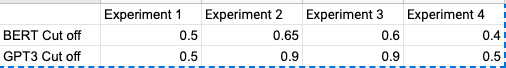

### Presenting the Test data embeddings in 2D space

In [259]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns
import plotly.express as px
import plotly.graph_objs as go

set_seed()
cut_off = 0.65
classification_model_loaded = Industry_Group_Classification_Model(emb_length=768, pred_length=24)
classification_model_loaded.load_state_dict(torch.load("Phase2_2:bert.pt"))
classification_model_loaded = classification_model_loaded.cuda()

test_data = pd.read_parquet('dataset_4.parquet')
y = torch.tensor(list(test_data["labels"]))

hand_labels = pd.read_parquet('test_data_v2_with_embeddings.parquet')["hand_labeled"]


classification_model_loaded.eval()
with torch.no_grad():
  pred = classification_model_loaded(list(test_data["bert_mpnet_embeddings"]))

  outputs = pred.cpu().numpy()
scaler = StandardScaler()
outputs = scaler.fit_transform(outputs)
pca = PCA(n_components=2)
outputs = pca.fit_transform(outputs)
outputs = pd.DataFrame(outputs, columns=["x","y"])
outputs["labels"] = hand_labels
outputs.head(5)

# plt.scatter(x=)


,x,y,labels
0,-2.345046,0.665233,"[Media & Entertainment, Software & Services]"
1,-0.947039,2.188928,"[Media & Entertainment, Software & Services]"
2,-1.920789,-2.160141,[Utilities]
3,2.648076,0.961297,[Insurance]
4,2.275019,0.531370,[Insurance]


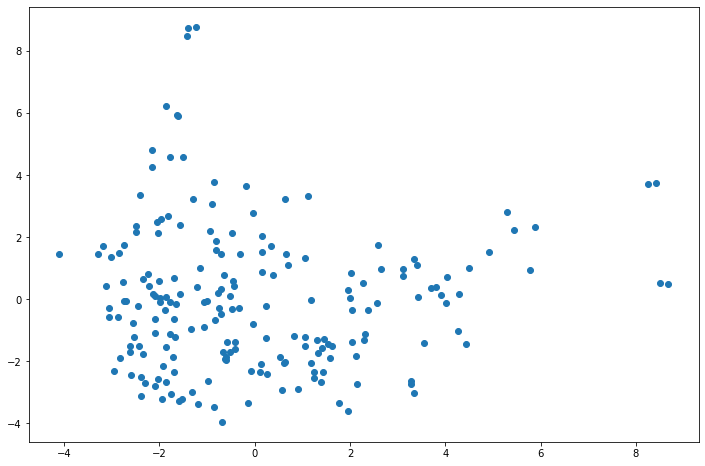

In [260]:
plt.figure(figsize=(12,8))
plt.scatter(outputs["x"], outputs["y"])
plt.show()

In [262]:
import plotly.express as px

fig = px.scatter(outputs, x="x", y="y", hover_data=["labels"])
fig.show()